<a href="https://colab.research.google.com/github/LucasEduardo08/paic_serie_temporal/blob/main/V2_ProjetoPAIC_S%C3%A9riesTemporais_LucasEduardo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<iframe src="https://trinket.io/embed/glowscript/9e44505de3" width="100%" height="356" frameborder="0" marginwidth="0" marginheight="0" allowfullscreen></iframe>

In [ ]:
"""
Mudança no pré-processamento
- Começar a aplicar a diferenciação
- testar janelas para treinar e prever (5, 10, 15, 20)
Ex.: treinar com janela de 5 para prever 5 dias e assim vai
- tabela com os erros:
                  5. |  10.  | 15.  |   20
Arima.  |
Sarima |
...

- testar com e sem pre-processamento
-objetivo: saber como os modelos lidam com diferentes cenários.


-> testar o conceito de janelas para os modelos clássicos
"""

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.0 MB/s eta 0:00:00


In [ ]:
# importando as bibliotecas necessárias
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import Dense,LSTM, GRU, Dropout
from keras.models import load_model
from keras import Input, layers, Model, optimizers
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

# 1. Carregamento dos dados

In [ ]:
# Ticket das ações que serão usadas no projeto
lista_acao = ['BBAS3.SA', 'TAEE11.SA', 'CSMG3.SA', 'MGLU3.SA', 'TOTS3.SA', 'BOVA11.SA']

# Importando os datasets
bb_dataset = yf.download(lista_acao[0], start='2019-12-29', end='2023-08-01')
taesa_dataset = yf.download(lista_acao[1], start='2019-12-29', end='2023-08-01')
copasa_dataset = yf.download(lista_acao[2], start='2019-12-29', end='2023-08-01')
magazine_dataset = yf.download(lista_acao[3], start='2019-12-29', end='2023-08-01')
totvs_dataset = yf.download(lista_acao[4], start='2019-12-29', end='2023-08-01')
bova_dataset = yf.download(lista_acao[5], start='2019-12-29', end='2023-08-01')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# Pré-processamentos dos dados

## 2.1. Funções

In [ ]:
# Função para criar as janelas
def n_janelas(time_serie, janela: int):
  # Dados de treino e resposta do treino que serão preenchidos
  treino = []
  resposta = []

  # Coloca n valores no treino e o próximo no de resposta
  for i in range(janela, len(time_serie)):
    treino.append(time_serie[i - janela:i])
    resposta.append(time_serie[i])

  return treino, resposta

In [ ]:
# Função para dividir os datasets em treino e teste com
def split_dataset(time_serie_x, time_serie_y, porc_train):
  """
  time_serie_x: Dados preditores
  time_serie_y: Dados alvos
  porc_train: Porcentagem de dados de treinamento
  """

  # tamanho dos datasets
  tam = len(time_serie_x)

  # 80% dos dados serão de treinamento e 20% serão pra teste (exemplo)
  ponto_separacao = int(tam * porc_train)

  # treino e teste
  time_serie_train_x, time_serie_train_y = time_serie_x[0:ponto_separacao], time_serie_y[0:ponto_separacao]
  time_serie_test_x, time_serie_test_y = time_serie_x[ponto_separacao:], time_serie_y[ponto_separacao:]

  # Retorna os arrays de treino e teste
  return time_serie_train_x, time_serie_test_x, time_serie_train_y, time_serie_test_y

In [ ]:
def diff_reverse(dataset, value_reference):
  '''
  dataset: dados diferenciados
  value_referece: valor de referência para reverter
  '''

  # Processo inverso ao diff()
  reverse = np.cumsum(np.concatenate([[value_reference], dataset]))

  # Retorna os dados absolutos
  return reverse

## 2.2 Etapa de transformação

In [ ]:
# Pegando os valores de fechamento e transformano em um dataframe
bb_close = pd.DataFrame(bb_dataset['Close'])
taesa_close = pd.DataFrame(taesa_dataset['Close'])
copasa_close = pd.DataFrame(copasa_dataset['Close'])
magazine_close = pd.DataFrame(magazine_dataset['Close'])
totvs_close = pd.DataFrame(totvs_dataset['Close'])
bova_close = pd.DataFrame(bova_dataset['Close'])

# Colocando as datas como colunas
bb_close.reset_index('Date', inplace=True)
taesa_close.reset_index('Date', inplace=True)
copasa_close.reset_index('Date', inplace=True)
magazine_close.reset_index('Date', inplace=True)
totvs_close.reset_index('Date', inplace=True)
bova_close.reset_index('Date', inplace=True)

### 2.2.1. Sem diferenciação

#### Janela de 5 dias para prever 5 dias



In [ ]:
np.array(bb_close['Close'])[-12:-1]

array([47.68999863, 48.11000061, 48.27000046, 47.43000031, 47.95000076,
       48.52000046, 47.56999969, 47.31999969, 47.72000122, 46.74000168,
       47.27999878])

In [ ]:
# Separa os dados em janelas de 5 dias como anterior e 1 dia para prever
bb_anterior_5, bb_previsao_5 = n_janelas(np.array(bb_close['Close'])[0: -11], janela=5)
bb_anterior_5[-1], bb_previsao_5[-1]

(array([49.95999908, 49.04000092, 48.34000015, 47.56000137, 48.00999832]),
 47.689998626708984)

In [ ]:
# Cria a base de dados para o treinamento, validação e teste
bb_teste_5_x, bb_teste_5_y = np.array(bb_close['Close'])[-11: -6], np.array(bb_close['Close'])[-6: -1]

# Chama a função e cria 6 arrays sendo 4 para ser passado para o modelos (treino e validação) e 2 para o teste
bb_treino_5_x, bb_val_5_x, bb_treino_5_y, bb_val_5_y = split_dataset(bb_anterior_5, bb_previsao_5, 0.8)

# Transforma em um array
bb_treino_5_x, bb_val_5_x = np.array(bb_treino_5_x), np.array(bb_val_5_x)
bb_treino_5_y, bb_val_5_y = np.array(bb_treino_5_y), np.array(bb_val_5_y)
bb_teste_5_x, bb_teste_5_y = np.array(bb_teste_5_x), np.array(bb_teste_5_y)

bb_treino_5_x[0], bb_val_5_x[0], bb_treino_5_y[0], bb_val_5_y[0]

(array([52.81999969, 53.79999924, 53.70999908, 53.        , 52.59999847]),
 array([39.50999832, 38.11000061, 38.59000015, 38.81999969, 37.02000046]),
 52.119998931884766,
 37.900001525878906)

In [ ]:
print(len(bb_treino_5_x), len(bb_treino_5_y))
print(len(bb_val_5_x),len(bb_val_5_y))
print(len(bb_teste_5_x), len(bb_teste_5_y))

700 700
175 175
5 5


#### Janela de 5 dias para prever 10 dias

In [ ]:
np.array(bb_close['Close'])[-16:-1]

array([49.04000092, 48.34000015, 47.56000137, 48.00999832, 47.68999863,
       48.11000061, 48.27000046, 47.43000031, 47.95000076, 48.52000046,
       47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878])

In [ ]:
# Separa os dados em janelas de 5 dias como anterior e 1 dia para prever
bb_anterior_5, bb_previsao_5 = n_janelas(np.array(bb_close['Close'])[0: -16], janela=5)
bb_anterior_5[-1], bb_previsao_5[-1]

(array([49.40000153, 50.38999939, 50.06999969, 49.74000168, 49.00999832]),
 49.959999084472656)

In [ ]:
# Cria a base de dados para o treinamento, validação e teste
bb_teste_5_x, bb_teste_5_y = np.array(bb_close['Close'])[-16: -11], np.array(bb_close['Close'])[-11: -1]

# Chama a função e cria 4 arrays onde 2 é para treino e 2 para validação
bb_treino_5_x, bb_val_5_x, bb_treino_5_y, bb_val_5_y = split_dataset(bb_anterior_5, bb_previsao_5, 0.8)

# Transforma em um array
bb_treino_5_x, bb_val_5_x = np.array(bb_treino_5_x), np.array(bb_val_5_x)
bb_treino_5_y, bb_val_5_y = np.array(bb_treino_5_y), np.array(bb_val_5_y)
bb_teste_5_x, bb_teste_5_y = np.array(bb_teste_5_x), np.array(bb_teste_5_y)

bb_treino_5_x[0], bb_treino_5_y[0], bb_val_5_x[0], bb_val_5_y[0]

(array([52.81999969, 53.79999924, 53.70999908, 53.        , 52.59999847]),
 52.119998931884766,
 array([41.65000153, 43.59999847, 44.68000031, 40.20000076, 39.50999832]),
 38.11000061035156)

In [ ]:
print(len(bb_treino_5_x), len(bb_treino_5_y))
print(len(bb_val_5_x),len(bb_val_5_y))
print(len(bb_teste_5_x), len(bb_teste_5_y))

696 696
174 174
5 10


### 2.2.2. Com diferenciação

#### janela de 5 dias para prever 5 dias

In [ ]:
# Achar o valor de referência
bb_referencia = bb_close['Close'][884]
bb_referencia

48.52000045776367

In [ ]:
bb_close_diff = bb_close['Close'].diff()[1:]
bb_close_diff[0:4]

1    0.980000
2   -0.090000
3   -0.709999
4   -0.400002
Name: Close, dtype: float64

In [ ]:
# Separa os dados em janelas de 5 dias como anterior e 1 dia para prever, mas os dados já estão diferenciados
bb_anterior_5_diff, bb_previsao_5_diff = n_janelas(np.array(bb_close_diff)[0: -11], janela=5)
bb_anterior_5_diff[-1], bb_previsao_5_diff[-1]

(array([ 0.95000076, -0.91999817, -0.70000076, -0.77999878,  0.44999695]),
 -0.31999969482421875)

In [ ]:
# Cria a base de dados para teste
bb_teste_5_x_diff, bb_teste_5_y_diff = np.array(bb_close_diff)[-11: -6], np.array(bb_close_diff)[-6: -1]

# Chama a função e cria 4 arrays que serão passados para o modelo
bb_treino_5_x_diff, bb_val_5_x_diff, bb_treino_5_y_diff, bb_val_5_y_diff = split_dataset(bb_anterior_5_diff, bb_previsao_5_diff, 0.8)

# Transforma em um array
bb_treino_5_x_diff, bb_val_5_x_diff = np.array(bb_treino_5_x_diff), np.array(bb_val_5_x_diff)
bb_treino_5_y_diff, bb_val_5_y_diff = np.array(bb_treino_5_y_diff), np.array(bb_val_5_y_diff)
bb_teste_5_x_diff, bb_teste_5_y_diff = np.array(bb_teste_5_x_diff), np.array(bb_teste_5_y_diff)

bb_treino_5_x_diff[0], bb_val_5_x_diff[0], bb_treino_5_y_diff[0], bb_val_5_y_diff[0]

(array([ 0.97999954, -0.09000015, -0.70999908, -0.40000153, -0.47999954]),
 array([-0.69000244, -1.39999771,  0.47999954,  0.22999954, -1.79999924]),
 -1.05999755859375,
 0.8800010681152344)

In [ ]:
print(len(bb_treino_5_x_diff), len(bb_treino_5_y_diff))
print(len(bb_val_5_x_diff),len(bb_val_5_y_diff))
print(len(bb_teste_5_x_diff), len(bb_teste_5_y_diff))

699 699
175 175
5 5


#### Janela de 5 dias para prever 10 dias

In [ ]:
# Achar o valor de referência
bb_referencia = bb_close['Close'][879]
bb_referencia

47.689998626708984

In [ ]:
bb_close_diff = bb_close['Close'].diff()[1:]
bb_close_diff[0:4]

1    0.980000
2   -0.090000
3   -0.709999
4   -0.400002
Name: Close, dtype: float64

In [ ]:
# Separa os dados em janelas de 5 dias como anterior e 1 dia para prever, mas os dados já estão diferenciados
bb_anterior_5_diff, bb_previsao_5_diff = n_janelas(np.array(bb_close_diff)[0: 874], janela=5)
bb_anterior_5_diff[-1], bb_previsao_5_diff[-1]

(array([-0.64999771,  0.98999786, -0.31999969, -0.32999802, -0.73000336]),
 0.9500007629394531)

In [ ]:
# Cria a base de dados para teste
bb_teste_5_x_diff, bb_teste_5_y_diff = np.array(bb_close_diff)[874: 879], np.array(bb_close_diff)[879: -1]

# Chama a função e cria 4 arrays que serão passados para o modelo
bb_treino_5_x_diff, bb_val_5_x_diff, bb_treino_5_y_diff, bb_val_5_y_diff = split_dataset(bb_anterior_5_diff, bb_previsao_5_diff, 0.8)

# Transforma em um array
bb_treino_5_x_diff, bb_val_5_x_diff = np.array(bb_treino_5_x_diff), np.array(bb_val_5_x_diff)
bb_treino_5_y_diff, bb_val_5_y_diff = np.array(bb_treino_5_y_diff), np.array(bb_val_5_y_diff)
bb_teste_5_x_diff, bb_teste_5_y_diff = np.array(bb_teste_5_x_diff), np.array(bb_teste_5_y_diff)

bb_treino_5_x_diff[0], bb_treino_5_y_diff[0], bb_val_5_x_diff[0], bb_val_5_y_diff[0]

(array([ 0.97999954, -0.09000015, -0.70999908, -0.40000153, -0.47999954]),
 -1.05999755859375,
 array([ 1.70000076,  1.94999695,  1.08000183, -4.47999954, -0.69000244]),
 -1.3999977111816406)

In [ ]:
print(len(bb_treino_5_x_diff), len(bb_treino_5_y_diff))
print(len(bb_val_5_x_diff),len(bb_val_5_y_diff))
print(len(bb_teste_5_x_diff), len(bb_teste_5_y_diff))

695 695
174 174
5 10


### Autocorrelação

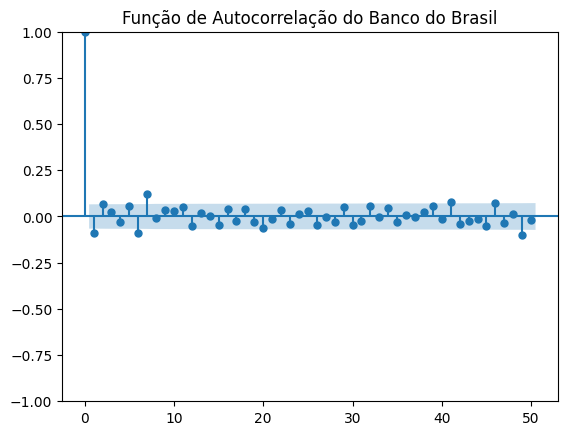

In [ ]:
# Calculando a PACF   MA(q) = {0, 1, 6, 7, 49}
lags = 50  # Número de lags para considerar
acf_bb = acf(bb_close['Close'].diff()[1:], nlags=lags)
acf_bb
# Plotando a PACF
plot_acf(bb_close['Close'].diff()[1:], lags=lags, title="Função de Autocorrelação do Banco do Brasil")
plt.show()

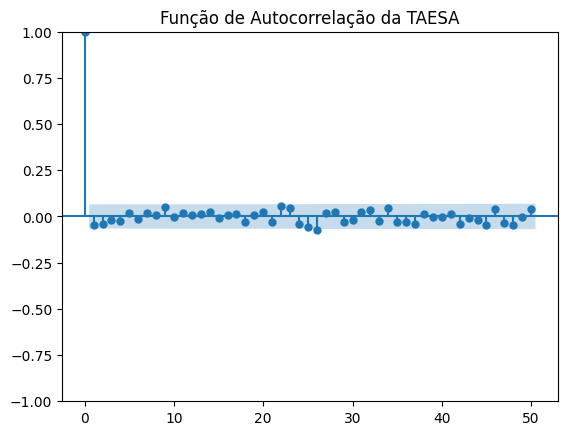

In [ ]:
# Calculando a PACF   MA(q) = {0, 27}
lags = 50  # Número de lags para considerar
acf_taesa = acf(taesa_close['Close'].diff()[1:], nlags=lags)

# Plotando a PACF
plot_acf(taesa_close['Close'].diff()[1:], lags=lags, title="Função de Autocorrelação da TAESA")
plt.show()

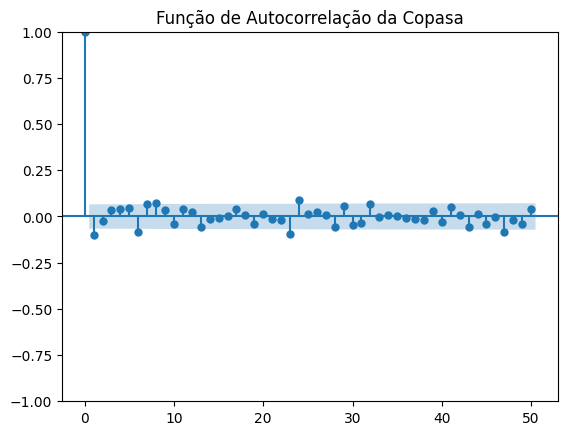

In [ ]:
# Calculando a PACF   MA(q) = {0, 1, 6, 23, 24, 47}
lags = 50  # Número de lags para considerar
acf_copasa = acf(copasa_close['Close'].diff()[1:], nlags=lags)

# Plotando a PACF
plot_acf(copasa_close['Close'].diff()[1:], lags=lags, title="Função de Autocorrelação da Copasa")
plt.show()

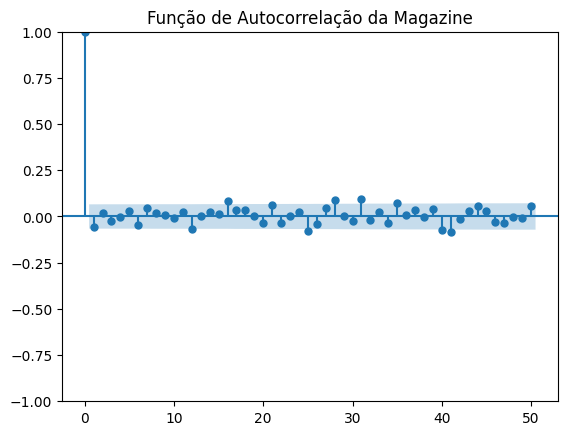

In [ ]:
# Calculando a PACF   MA(q) = {0, 16, 25, 28, 31, 40 ,41}
lags = 50  # Número de lags para considerar
acf_magazine = acf(magazine_close['Close'].diff()[1:], nlags=lags)

# Plotando a PACF
plot_acf(magazine_close['Close'].diff()[1:], lags=lags, title="Função de Autocorrelação da Magazine")
plt.show()

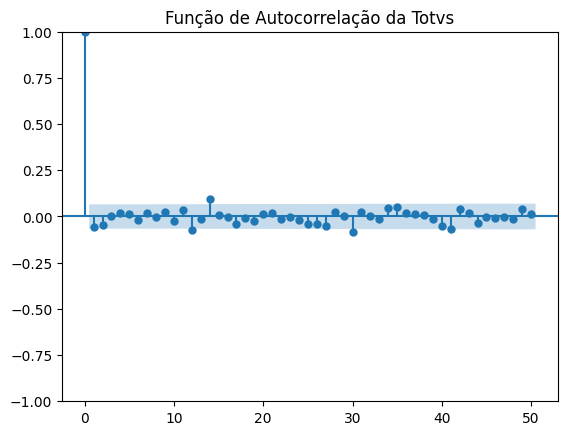

In [ ]:
# Calculando a PACF   MA(q) = {0, 12, 14, 30}
lags = 50  # Número de lags para considerar
acf_totvs = acf(totvs_close['Close'].diff()[1:], nlags=lags)

# Plotando a PACF
plot_acf(totvs_close['Close'].diff()[1:], lags=lags, title="Função de Autocorrelação da Totvs")
plt.show()

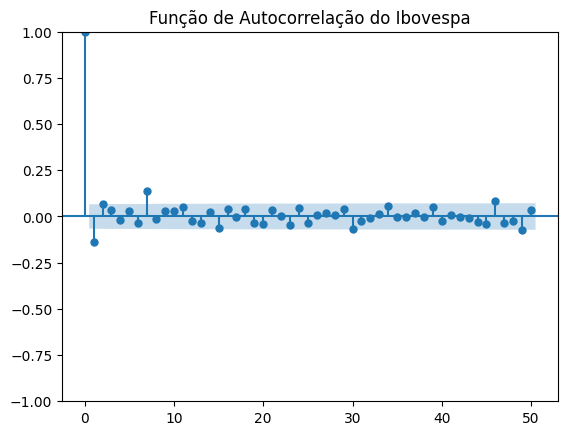

In [ ]:
# Calculando a PACF   MA(q) = {0, 1, 7}
lags = 50  # Número de lags para considerar
acf_bova = acf(bova_close['Close'].diff()[1:], nlags=lags)

# Plotando a PACF
plot_acf(bova_close['Close'].diff()[1:], lags=lags, title="Função de Autocorrelação do Ibovespa")
plt.show()

### Autocorrelação Parcial

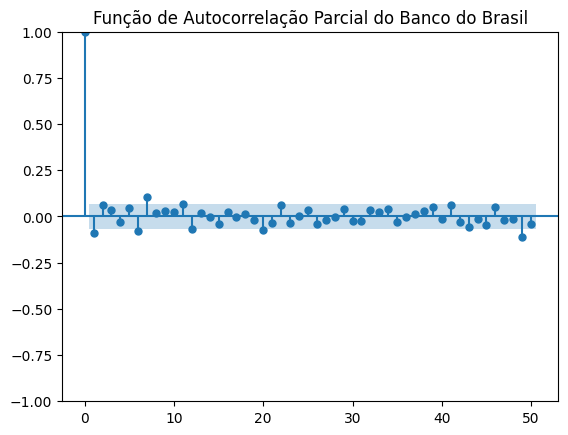

In [ ]:
# Calculando a PACF   AR(p) = {0, 1, 6, 7, 49}
lags = 50  # Número de lags para considerar
pacf_bb = pacf(bb_close['Close'].diff()[1:], nlags=lags)
#pacf_values
# Plotando a PACF
plot_pacf(bb_close['Close'].diff()[1:], lags=lags, title="Função de Autocorrelação Parcial do Banco do Brasil")
plt.show()

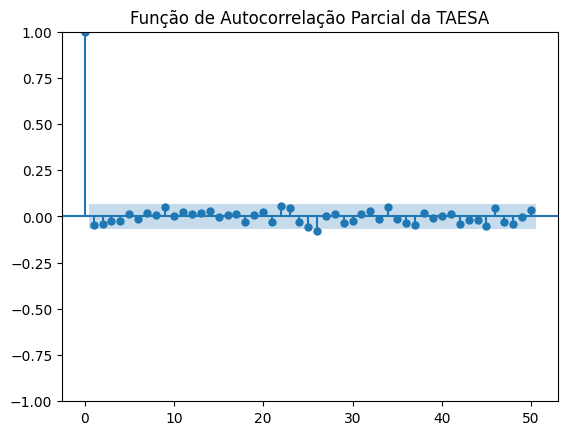

In [ ]:
# Calculando a PACF   AR(p) = {0, 26}
lags = 50  # Número de lags para considerar
pacf_taesa = pacf(taesa_close['Close'].diff()[1:], nlags=lags)

# Plotando a PACF
plot_pacf(taesa_close['Close'].diff()[1:], lags=lags, title="Função de Autocorrelação Parcial da TAESA")
plt.show()

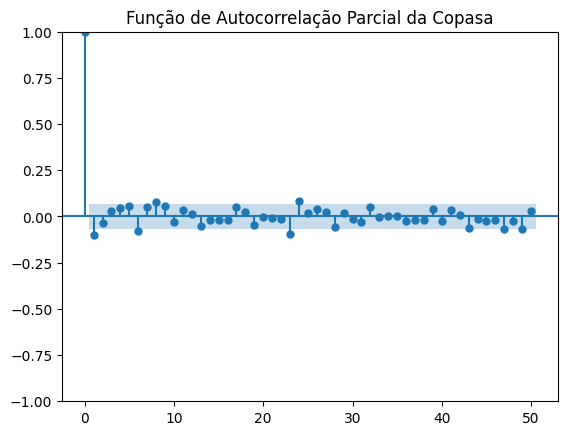

In [ ]:
# Calculando a PACF   AR(p) = {0, 1, 6, 23, 24}
lags = 50  # Número de lags para considerar
pacf_copasa = pacf(copasa_close['Close'].diff()[1:], nlags=lags)

# Plotando a PACF
plot_pacf(copasa_close['Close'].diff()[1:], lags=lags, title="Função de Autocorrelação Parcial da Copasa")
plt.show()

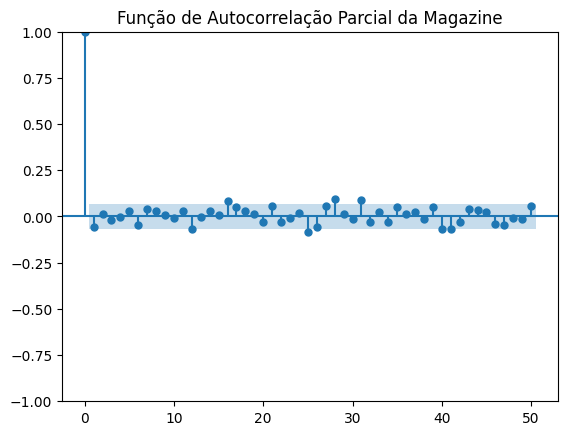

In [ ]:
# Calculando a PACF   AR(p) = {0, 16, 25, 28, 31, }
lags = 50  # Número de lags para considerar
pacf_magazine = pacf(magazine_close['Close'].diff()[1:], nlags=lags)

# Plotando a PACF
plot_pacf(magazine_close['Close'].diff()[1:], lags=lags, title="Função de Autocorrelação Parcial da Magazine")
plt.show()

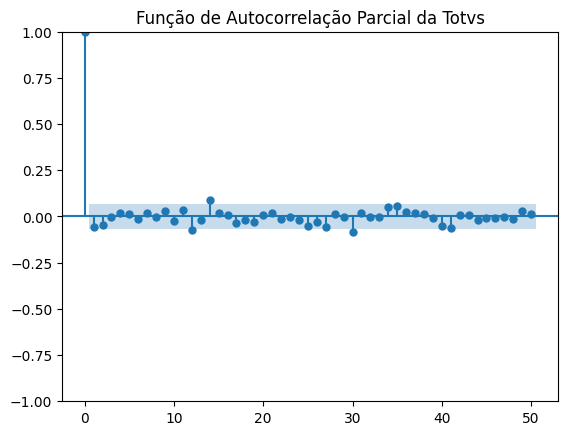

In [ ]:
# Calculando a PACF   AR(p) = {0, 12, 14, 30}
lags = 50  # Número de lags para considerar
pacf_totvs = pacf(totvs_close['Close'].diff()[1:], nlags=lags)

# Plotando a PACF
plot_pacf(totvs_close['Close'].diff()[1:], lags=lags, title="Função de Autocorrelação Parcial da Totvs")
plt.show()

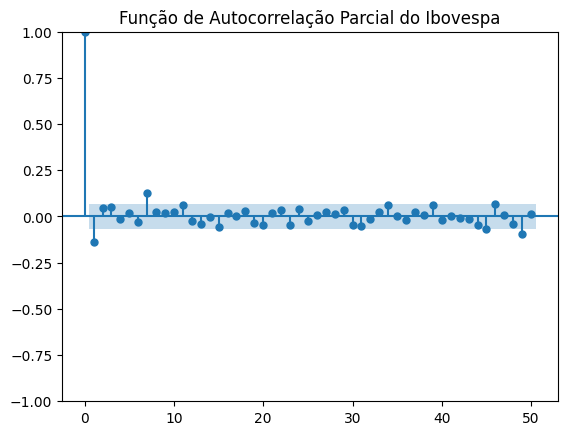

In [ ]:
# Calculando a PACF   AR(p) = {0, 1, 7, 49}
lags = 50  # Número de lags para considerar
pacf_bova = pacf(bova_close['Close'].diff()[1:], nlags=lags)

# Plotando a PACF
plot_pacf(bova_close['Close'].diff()[1:], lags=lags, title="Função de Autocorrelação Parcial do Ibovespa")
plt.show()

# 3. Modelos

## Funções

In [ ]:
def prever_x_dias(dados_teste, modelo, dias) -> np.array:
  """
  dados_teste: os dados de teste
  modelos: modelo já treinado
  dias: quantidade de dias para ser previsto
  """

  # Previsão iterativa para toda a janela de teste
  previsao = []

  # Use os últimos dados de treino como ponto de partida para a previsão
  input_sequence = dados_teste.tolist()

  for i in range(0, dias):
      # Faça a previsão para o próximo passo
      next_step = modelo.predict(np.array([input_sequence]))[0, 0]

      # Adicione a previsão à sequência de entrada para o próximo passo
      input_sequence.pop(0)
      input_sequence.append(next_step)

      # Salve a previsão
      previsao.append(next_step)

  # Converta para um array numpy
  previsao = np.array(previsao)

  # Retorna as previsões
  return previsao

In [ ]:
def grafico_history(history, title=str):
  # 2 gráficos em um
  fig, ax = plt.subplots(1,2, figsize=(14,6))

  # 1º gráfico
  ax[0].plot(history.history['loss'], color='b', label="Training loss")
  ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
  legend = ax[0].legend(loc='best', shadow=True)

  # 2º gráfico
  ax[1].plot(history.history['mae'], color='b', label="Training mae")
  ax[1].plot(history.history['val_mae'], color='r',label="Validation mae")
  legend = ax[1].legend(loc='best', shadow=True)

  plt.savefig(title)

## 3.2. SARIMA


### BB

#### Dados sem pre-processamento

##### Prever 5 dias

In [ ]:
# treino e teste
treino, teste = np.array(bb_close['Close'])[0: -6], np.array(bb_close['Close'])[-6: -1]
len(treino), len(teste)

(885, 5)

In [ ]:
# Encontrando os melhores parâmetros
bb_sarima_5 = auto_arima(treino,
                     start_p=0, start_q=0, max_p=10, max_q=10,
                     d=None, m=4, seasonal = True,
                     D=None, start_Q=1, start_P=1, max_P=10, max_Q=10,
                     trace=True,
                     error_action='ignore', suppress_warnings=True,
                     stepwise=False)

 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=2336.690, Time=0.43 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=2337.830, Time=0.87 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=2339.766, Time=1.33 sec
 ARIMA(0,1,0)(0,0,3)[4] intercept   : AIC=2339.325, Time=2.05 sec
 ARIMA(0,1,0)(0,0,4)[4] intercept   : AIC=2340.504, Time=1.91 sec
 ARIMA(0,1,0)(0,0,5)[4] intercept   : AIC=2339.179, Time=2.73 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=2337.843, Time=0.16 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=2338.671, Time=1.01 sec
 ARIMA(0,1,0)(1,0,2)[4] intercept   : AIC=2335.381, Time=1.98 sec
 ARIMA(0,1,0)(1,0,3)[4] intercept   : AIC=2335.444, Time=2.21 sec
 ARIMA(0,1,0)(1,0,4)[4] intercept   : AIC=2337.271, Time=5.11 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=2339.807, Time=0.41 sec
 ARIMA(0,1,0)(2,0,1)[4] intercept   : AIC=inf, Time=2.96 sec
 ARIMA(0,1,0)(2,0,2)[4] intercept   : AIC=2336.048, Time=1.78 sec
 ARIMA(0,1,0)(2,0,3)[4] intercept   : AIC=2337.143, Time=3.60 sec
 ARIMA(0,1,0)(3

In [ ]:
# Treinamento
bb_sarima_5.fit(treino)

# Previsão dos preços
bb_sarima_5_previsao = bb_sarima_5.predict(n_periods=len(teste), return_conf_int=False)
bb_teste_5_y, bb_sarima_5_previsao

(array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([48.60646639, 48.58173961, 48.58261282, 48.58560348, 48.5652252 ]))

##### Prever 10 dias

In [ ]:
# treino e teste
treino = np.array(bb_close['Close'])[0: -11]
len(treino), len(bb_teste_5_y)

(880, 10)

In [ ]:
# Encontrando os melhores parâmetros
bb_sarima_10 = auto_arima(treino,
                     start_p=0, start_q=0, max_p=10, max_q=10,
                     d=None, m=12, seasonal = True,
                     D=None, start_Q=1, start_P=1, max_P=10, max_Q=10,
                     trace=True,
                     error_action='ignore', suppress_warnings=True,
                     stepwise=False)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2326.646, Time=0.25 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2326.281, Time=0.66 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=2328.046, Time=2.12 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=2329.957, Time=2.73 sec
 ARIMA(0,1,0)(0,0,4)[12] intercept   : AIC=2331.946, Time=5.23 sec
 ARIMA(0,1,0)(0,0,5)[12] intercept   : AIC=2328.953, Time=12.57 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2326.213, Time=0.33 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2328.093, Time=0.48 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=2330.004, Time=3.03 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=2331.957, Time=4.75 sec
 ARIMA(0,1,0)(1,0,4)[12] intercept   : AIC=2333.956, Time=7.24 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=2328.070, Time=0.90 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=2330.092, Time=1.16 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=12.82 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=inf, Time=15.04 sec
 A

In [ ]:
# Treinamento
bb_sarima_10.fit(treino)

# Previsão dos preços
bb_sarima_10_previsao = bb_sarima_10.predict(n_periods=len(bb_teste_5_y), return_conf_int=False)
bb_teste_5_y, bb_sarima_10_previsao

(array([48.11000061, 48.27000046, 47.43000031, 47.95000076, 48.52000046,
        47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([47.5643401 , 47.7105447 , 47.53157708, 47.68911414, 47.54741698,
        47.64054204, 47.57359652, 47.59461012, 47.5885824 , 47.56428417]))

#### Dados com pre-processamento

##### Prever 5 dias

In [ ]:
# treino
treino_diff = np.array(bb_close_diff)[0: -6]
len(treino), len(bb_teste_5_y)

(884, 5)

In [ ]:
# Encontrando os melhores parâmetros
bb_sarima_5_diff = auto_arima(treino_diff,
                     start_p=0, start_q=0, max_p=15, max_q=15,
                     d=0, m=12, seasonal = True,
                     D=0, start_Q=1, start_P=1, max_P=15, max_Q=15,
                     trace=True,
                     error_action='ignore', suppress_warnings=True,
                     stepwise=False)

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2336.690, Time=0.37 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=2336.179, Time=0.47 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=2337.971, Time=1.59 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=2339.879, Time=2.69 sec
 ARIMA(0,0,0)(0,0,4)[12] intercept   : AIC=2341.875, Time=6.81 sec
 ARIMA(0,0,0)(0,0,5)[12] intercept   : AIC=2338.779, Time=12.56 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=2336.112, Time=0.44 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=2338.016, Time=0.93 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=2339.932, Time=4.25 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=2341.880, Time=3.15 sec
 ARIMA(0,0,0)(1,0,4)[12] intercept   : AIC=2343.420, Time=20.90 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=2337.995, Time=1.56 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=2340.016, Time=1.84 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=9.07 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=28.21 sec
 A

In [ ]:
# Treinamento
bb_sarima_5_diff.fit(treino)

# Previsão dos preços
bb_sarima_5_previsao_diff = bb_sarima_5_diff.predict(n_periods=len(bb_teste_5_y), return_conf_int=False)
bb_sarima_5_previsao_diff = diff_reverse(bb_sarima_5_previsao_diff, bb_referencia)[1:]

bb_teste_5_y, bb_sarima_5_previsao_diff

(array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([48.60599246, 48.58112915, 48.58186657, 48.58480605, 48.56427966]))

##### Prever 10 dias

In [ ]:
# treino
treino_diff = np.array(bb_close_diff)[0: -11]
len(treino_diff), len(bb_teste_5_y)

(879, 10)

In [ ]:
# Encontrando os melhores parâmetros
bb_sarima_10_diff = auto_arima(treino_diff,
                     start_p=0, start_q=0, max_p=15, max_q=15,
                     d=0, m=12, seasonal = True,
                     D=0, start_Q=1, start_P=1, max_P=15, max_Q=15,
                     trace=True,
                     error_action='ignore', suppress_warnings=True,
                     stepwise=False)

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2326.646, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=2326.281, Time=0.42 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=2328.046, Time=1.28 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=2329.957, Time=2.49 sec
 ARIMA(0,0,0)(0,0,4)[12] intercept   : AIC=2331.946, Time=6.18 sec
 ARIMA(0,0,0)(0,0,5)[12] intercept   : AIC=2328.953, Time=12.60 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=2326.213, Time=0.31 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=2328.093, Time=0.75 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=2330.004, Time=4.81 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=2331.957, Time=2.87 sec
 ARIMA(0,0,0)(1,0,4)[12] intercept   : AIC=2333.956, Time=8.07 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=2328.070, Time=1.64 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=2330.092, Time=1.39 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=8.87 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=14.25 sec
 AR

In [ ]:
# Treinamento
bb_sarima_10_diff.fit(treino_diff)

# Previsão dos preços
bb_sarima_10_previsao_diff = bb_sarima_10_diff.predict(n_periods=len(bb_teste_5_y), return_conf_int=False)
bb_sarima_10_previsao_diff = diff_reverse(bb_sarima_10_previsao_diff, bb_referencia)[1:]

bb_teste_5_y, bb_sarima_10_previsao_diff

(array([48.11000061, 48.27000046, 47.43000031, 47.95000076, 48.52000046,
        47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([47.5643384 , 47.7105446 , 47.53157574, 47.68911372, 47.54741589,
        47.64054115, 47.57359579, 47.59460874, 47.58858194, 47.56428249]))

## 3.3. Holt-Winters

### BB

#### Dados sem pre-processamento

##### Prever 5 dias

In [ ]:
# Tamanho da janela que será passada para o modelo e tamanho da janela que será prevista
tam_treino, tam_teste = len(np.array(bb_close['Close'])[0: -6]), len(np.array(bb_close['Close'])[-6: -1])
tam_treino, tam_teste

(885, 5)

In [ ]:
# Criando o modelo
bb_hw_5 = ExponentialSmoothing(np.array(bb_close['Close'])[0: -6], trend='add' ,seasonal='mul', seasonal_periods=200)

# Treina o modelo
bb_resultado_hw_5 = bb_hw_5.fit()

# Prevendo os valores
bb_hw_5_previsao = bb_resultado_hw_5.predict(start=tam_treino, end=tam_treino + tam_teste - 1)

bb_teste_5_y, bb_hw_5_previsao

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


(array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([48.69397351, 47.18982699, 47.34921447, 47.1257321 , 47.00220502]))

##### Prever 10 dias

In [ ]:
# Tamanho da janela que será passada para o modelo e tamanho da janela que será prevista
tam_treino, tam_teste = len(np.array(bb_close['Close'])[0: -11]), len(bb_teste_5_y)
tam_treino, tam_teste

(880, 10)

In [ ]:
# Criando o modelo
bb_hw_10 = ExponentialSmoothing(np.array(bb_close['Close'])[0: -11], trend='add' ,seasonal='add', seasonal_periods=7)

# Treina o modelo
bb_resultado_hw_10 = bb_hw_10.fit()

# Prevendo os valores
bb_hw_10_previsao = bb_resultado_hw_10.predict(start=tam_treino, end=tam_treino + tam_teste - 1)

bb_teste_5_y, bb_hw_10_previsao

(array([48.11000061, 48.27000046, 47.43000031, 47.95000076, 48.52000046,
        47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([47.68139265, 47.59860605, 47.6014534 , 47.67611752, 47.66439769,
        47.77066066, 47.66250549, 47.63968081, 47.55689421, 47.55974157]))

#### Dados com pre-processamento

##### Prever 5 dias

In [ ]:
# Tamanho da janela que será passada para o modelo e tamanho da janela que será prevista
tam_treino, tam_teste = len(np.array(bb_close_diff)[0: -6]), len(np.array(bb_close['Close'])[-6: -1])
tam_treino, tam_teste

(884, 5)

In [ ]:
# Criando o modelo
bb_hw_5_diff = ExponentialSmoothing(np.array(bb_close_diff)[0: -6], trend='add' ,seasonal='add', seasonal_periods=220)

# Treina o modelo
bb_resultado_hw_5_diff = bb_hw_5_diff.fit()

# Prevendo os valores
bb_hw_5_previsao_diff = bb_resultado_hw_5_diff.predict(start=tam_treino, end=tam_treino + tam_teste - 1)
bb_hw_5_previsao_diff = diff_reverse(bb_hw_5_previsao_diff, bb_referencia)[1:]

bb_teste_5_y, bb_hw_5_previsao_diff

(array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([48.68141107, 47.75530629, 47.15422097, 46.81814487, 47.1270653 ]))

##### Prever 10 dias

In [ ]:
# Tamanho da janela que será passada para o modelo e tamanho da janela que será prevista
tam_treino, tam_teste = len(np.array(bb_close_diff)[0: -11]), len(bb_teste_5_y)
tam_treino, tam_teste

(879, 10)

In [ ]:
# Criando o modelo
bb_hw_10_diff = ExponentialSmoothing(np.array(bb_close_diff)[0: -11], trend='add' ,seasonal='add', seasonal_periods=202)

# Treina o modelo
bb_resultado_hw_10_diff = bb_hw_10_diff.fit()

# Prevendo os valores
bb_hw_10_previsao_diff = bb_resultado_hw_10_diff.predict(start=tam_treino, end=tam_treino + tam_teste - 1)
bb_hw_10_previsao_diff = diff_reverse(bb_hw_10_previsao_diff, bb_referencia)[1:]

bb_teste_5_y, bb_hw_10_previsao_diff

(array([48.11000061, 48.27000046, 47.43000031, 47.95000076, 48.52000046,
        47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([48.17225107, 47.84450644, 47.98424798, 47.66899367, 47.69874517,
        47.35599827, 46.54577004, 46.73050616, 47.51274203, 47.72749195]))

## 3.4. MLPs

### BB

#### Dados sem pre-processamento

##### Usar 5 dias para prever 5 dias

In [ ]:
# Carregar o modelo completo a partir do arquivo
bb_mlp_5_5 = load_model('bb_mlp_5_5.h5')

# Carregar os detalhes
with open('bb_mlp_5_5.json', 'r') as file:
    detalhes_treinamento = json.load(file)

# Acessar os detalhes
print('Épocas:', detalhes_treinamento['epocas'])
print('Batch Size:', detalhes_treinamento['batch_size'])
print('Otimizador:', detalhes_treinamento['otimizador'])

Épocas: 100
Batch Size: 20
Otimizador: adamactivation: 1º camada relu e 2º camada elu


In [ ]:
# Criação do modelo
bb_mlp_5_5 = Sequential()

# adicionando as camadas ocultas
bb_mlp_5_5.add(Dense(units=60, activation='elu', input_shape=(5,)))

bb_mlp_5_5.add(Dense(units=60, activation='relu'))

bb_mlp_5_5.add(Dense(units=60, activation='relu'))

# Camada de saída
bb_mlp_5_5.add(Dense(units=1))

# Compilar o modelo
bb_mlp_5_5.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Treinamento do modelo
history = bb_mlp_5_5.fit(bb_treino_5_x, bb_treino_5_y, epochs=100, batch_size=20, validation_data=(bb_val_5_x, bb_val_5_y))

Epoch 1/100
35/35 [==============================] - 2s 10ms/step - loss: 239.6894 - mae: 11.9181 - val_loss: 8.6835 - val_mae: 2.4201
Epoch 2/100
35/35 [==============================] - 0s 4ms/step - loss: 4.4430 - mae: 1.5946 - val_loss: 1.6694 - val_mae: 1.0067
Epoch 3/100
35/35 [==============================] - 0s 4ms/step - loss: 1.8761 - mae: 0.9440 - val_loss: 1.5891 - val_mae: 0.9800
Epoch 4/100
35/35 [==============================] - 0s 4ms/step - loss: 1.8044 - mae: 0.9181 - val_loss: 2.3423 - val_mae: 1.2312
Epoch 5/100
35/35 [==============================] - 0s 5ms/step - loss: 1.8415 - mae: 0.9366 - val_loss: 1.7351 - val_mae: 1.0319
Epoch 6/100
35/35 [==============================] - 0s 4ms/step - loss: 1.7914 - mae: 0.9150 - val_loss: 1.5755 - val_mae: 0.9762
Epoch 7/100
35/35 [==============================] - 0s 4ms/step - loss: 1.7777 - mae: 0.9070 - val_loss: 1.8965 - val_mae: 1.0869
Epoch 8/100
35/35 [==============================] - 0s 5ms/step - loss: 1.7414

In [ ]:
# Salvar o modelo para não perder os resultados
#bb_mlp_5_5.save('bb_mlp_5_5.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Salvar detalhes separadamente
detalhes_treinamento = {
    'epocas': 100,
    'batch_size': 20,
    'otimizador': 'adam',
    'activation': '1º camada relu e 2º camada elu'
}

with open('bb_mlp_5_5.json', 'w') as file:
    json.dump(detalhes_treinamento, file)

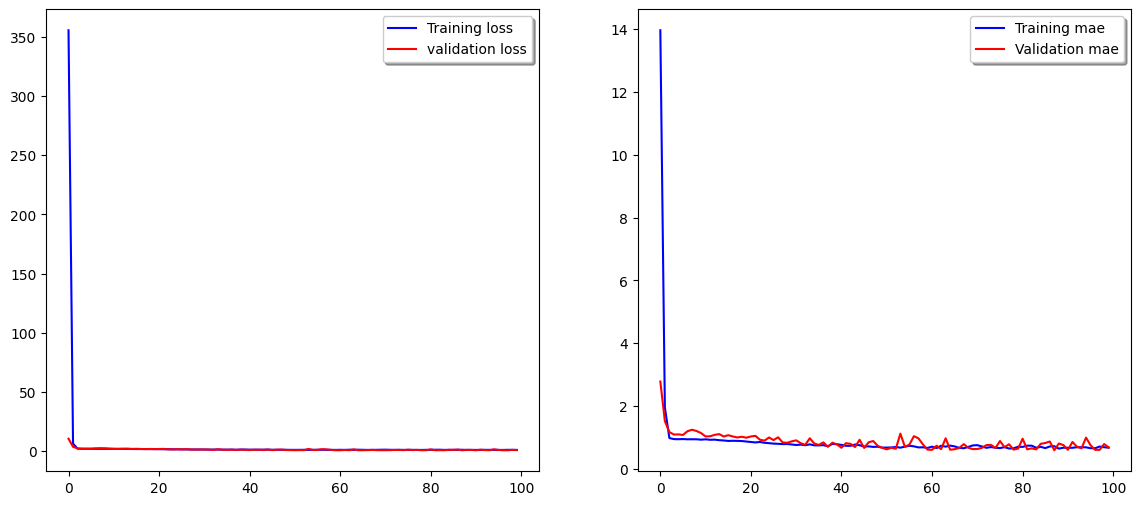

In [ ]:
grafico_history(history, "bb_mlp_5_5")

In [ ]:
# Faz a previsão
bb_mlp_5_5_previsao = prever_x_dias(bb_teste_5_x, bb_mlp_5_5)

1/1 [==============================] - 0s 16ms/step


In [ ]:
bb_teste_5_y, bb_mlp_5_5_previsao

(array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([47.914165, 47.805046, 47.582455, 47.16262 , 46.90913 ],
       dtype=float32))

##### Usar 5 dias para prever 10 dias

In [ ]:
# Carregar o modelo completo a partir do arquivo
bb_mlp_5_10 = load_model('bb_mlp_5_10.h5')

# Carregar os detalhes
with open('bb_mlp_5_10.json', 'r') as file:
    detalhes_treinamento = json.load(file)

# Acessar os detalhes
print('Épocas:', detalhes_treinamento['epocas'])
print('Batch Size:', detalhes_treinamento['batch_size'])
print('Otimizador:', detalhes_treinamento['otimizador'])

In [ ]:
# Criação do modelo
bb_mlp_5_10 = Sequential()

# adicionando as camadas ocultas
bb_mlp_5_10.add(Dense(units=60, activation='relu', input_shape=(5,)))

#bb_mlp_5_10.add(Dense(units=60, activation='relu'))

#bb_mlp_5_10.add(Dense(units=60, activation='relu'))

# Camada de saída
bb_mlp_5_10.add(Dense(units=1))

# Compilar o modelo
bb_mlp_5_10.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Treinamento do modelo
history = bb_mlp_5_10.fit(bb_treino_5_x, bb_treino_5_y, epochs=100, batch_size=20, validation_data=(bb_val_5_x, bb_val_5_y))

Epoch 1/100
35/35 [==============================] - 1s 8ms/step - loss: 1551.0199 - mae: 36.5047 - val_loss: 269.9701 - val_mae: 16.2552
Epoch 2/100
35/35 [==============================] - 0s 3ms/step - loss: 34.7680 - mae: 4.1854 - val_loss: 5.1423 - val_mae: 1.9461
Epoch 3/100
35/35 [==============================] - 0s 3ms/step - loss: 3.2174 - mae: 1.3381 - val_loss: 1.8537 - val_mae: 1.0702
Epoch 4/100
35/35 [==============================] - 0s 3ms/step - loss: 1.8582 - mae: 0.9443 - val_loss: 1.7979 - val_mae: 1.0480
Epoch 5/100
35/35 [==============================] - 0s 3ms/step - loss: 1.8481 - mae: 0.9336 - val_loss: 1.7612 - val_mae: 1.0316
Epoch 6/100
35/35 [==============================] - 0s 3ms/step - loss: 1.8421 - mae: 0.9342 - val_loss: 1.8119 - val_mae: 1.0552
Epoch 7/100
35/35 [==============================] - 0s 3ms/step - loss: 1.8331 - mae: 0.9296 - val_loss: 1.7890 - val_mae: 1.0464
Epoch 8/100
35/35 [==============================] - 0s 3ms/step - loss: 1.

In [ ]:
# Salvar o modelo para não perder os resultados
#bb_mlp_5_10.save('bb_mlp_5_10.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Salvar detalhes separadamente
detalhes_treinamento = {
    'epocas': 100,
    'batch_size': 20,
    'otimizador': 'adam',
    'activation': '1º camada relu'
}

with open('bb_mlp_5_10.json', 'w') as file:
    json.dump(detalhes_treinamento, file)

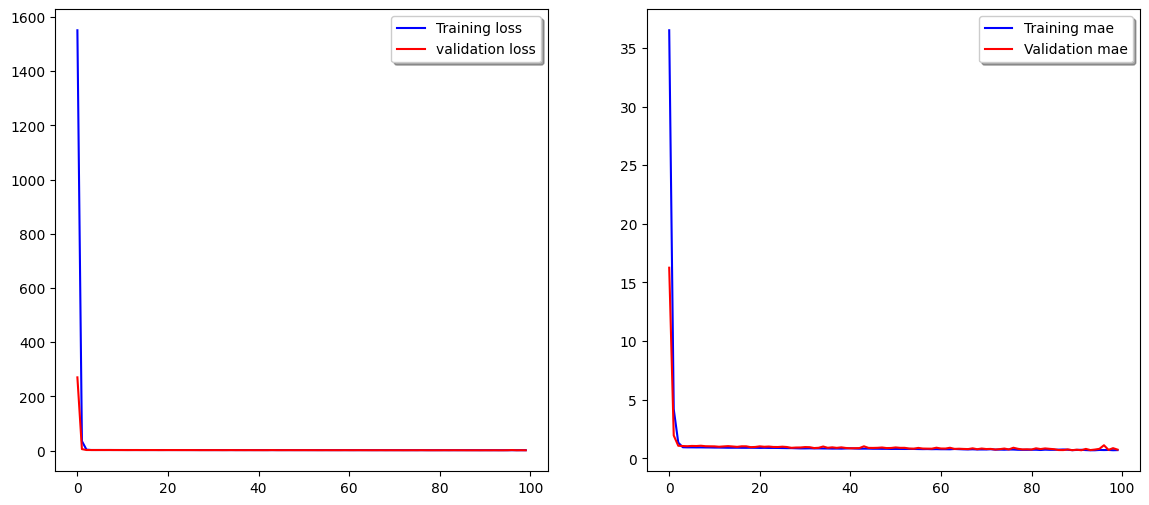

In [ ]:
grafico_history(history, "bb_mlp_5_10_history")

In [ ]:
# Faz a previsão
bb_mlp_5_10_previsao = prever_x_dias(bb_teste_5_x, bb_mlp_5_10, 10)

1/1 [==============================] - 0s 106ms/step


In [ ]:
bb_teste_5_y, bb_mlp_5_10_previsao

(array([48.11000061, 48.27000046, 47.43000031, 47.95000076, 48.52000046,
        47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([47.59524 , 47.301373, 47.1162  , 46.951218, 46.79192 , 46.617603,
        46.43537 , 46.25859 , 46.08825 , 45.92089 ], dtype=float32))

#### Dados com pre-processamento

##### Usar 5 dias para prever 5 dias

In [ ]:
# Carregar o modelo completo a partir do arquivo
bb_mlp_5_5_diff = load_model('bb_mlp_5_5_diff.h5')

# Carregar os detalhes
with open('bb_mlp_5_5_diff.json', 'r') as file:
    detalhes_treinamento = json.load(file)

# Acessar os detalhes
print('Épocas:', detalhes_treinamento['epocas'])
print('Batch Size:', detalhes_treinamento['batch_size'])
print('Otimizador:', detalhes_treinamento['otimizador'])

In [ ]:
# Criação do modelo
bb_mlp_5_5_diff = Sequential()

# adicionando as camadas ocultas
bb_mlp_5_5_diff.add(Dense(units=100, activation='relu', input_shape=(5,)))

#bb_mlp_5_5_diff.add(Dropout(0.2))

bb_mlp_5_5_diff.add(Dense(units=100, activation='relu'))

bb_mlp_5_5_diff.add(Dense(units=100, activation='relu'))

bb_mlp_5_5_diff.add(Dense(units=100, activation='relu'))

# Camada de saída
bb_mlp_5_5_diff.add(Dense(units=1))

# Compilar o modelo
bb_mlp_5_5_diff.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Treinamento do modelo
history = bb_mlp_5_5_diff.fit(bb_treino_5_x_diff, bb_treino_5_y_diff, epochs=150, batch_size=32, validation_data=(bb_val_5_x_diff, bb_val_5_y_diff))

Epoch 1/150
22/22 [==============================] - 1s 14ms/step - loss: 0.9049 - mae: 0.6219 - val_loss: 0.5669 - val_mae: 0.5853
Epoch 2/150
22/22 [==============================] - 0s 5ms/step - loss: 0.8528 - mae: 0.6098 - val_loss: 0.5630 - val_mae: 0.5816
Epoch 3/150
22/22 [==============================] - 0s 6ms/step - loss: 0.8127 - mae: 0.6022 - val_loss: 0.5932 - val_mae: 0.6003
Epoch 4/150
22/22 [==============================] - 0s 5ms/step - loss: 0.7937 - mae: 0.6009 - val_loss: 0.5806 - val_mae: 0.5888
Epoch 5/150
22/22 [==============================] - 0s 5ms/step - loss: 0.7634 - mae: 0.5918 - val_loss: 0.5831 - val_mae: 0.5900
Epoch 6/150
22/22 [==============================] - 0s 5ms/step - loss: 0.7178 - mae: 0.5815 - val_loss: 0.5903 - val_mae: 0.5905
Epoch 7/150
22/22 [==============================] - 0s 5ms/step - loss: 0.6874 - mae: 0.5714 - val_loss: 0.5820 - val_mae: 0.5872
Epoch 8/150
22/22 [==============================] - 0s 6ms/step - loss: 0.6503 - 

In [ ]:
# Salvar o modelo para não perder os resultados
#bb_mlp_5_5_diff.save('bb_mlp_5_5_diff.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Salvar detalhes separadamente
detalhes_treinamento = {
    'epocas': 150,
    'batch_size': 32,
    'otimizador': 'adam',
    'activation': '1 camada relu e 1 elu'
}

with open('bb_mlp_5_5_diff.json', 'w') as file:
    json.dump(detalhes_treinamento, file)

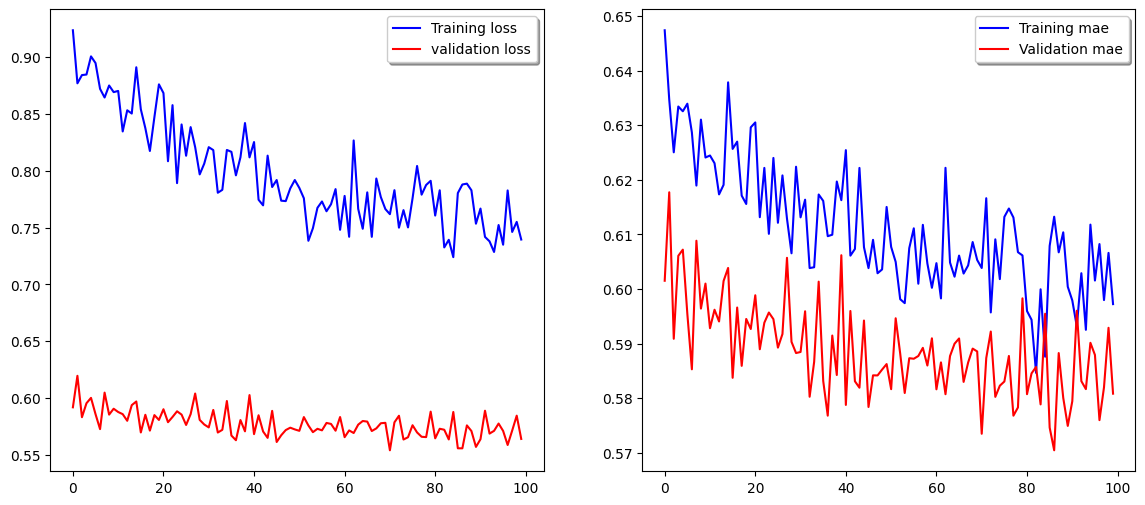

In [ ]:
grafico_history(history, "bb_mlp_5_5_diff_history")

In [ ]:
# Faz a previsão e logo em seguida é feito a reversão da diferenciação
bb_mlp_5_5_previsao_diff = prever_x_dias(bb_teste_5_x_diff, bb_mlp_5_5_diff)
bb_mlp_5_5_previsao_diff = diff_reverse(bb_mlp_5_5_previsao_diff, bb_referencia)[1:]

1/1 [==============================] - 0s 34ms/step


In [ ]:
bb_teste_5_y, bb_mlp_5_5_previsao_diff

(array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([47.58764815, 47.27184993, 45.97988623, 45.01957303, 45.36099014]))

In [ ]:
bb_teste_5_y, diff_reverse(bb_teste_5_y_diff, bb_referencia)[1:]

(array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]))

## 3.5. LSTM

### BB

#### Dados sem pre-processamento

##### Usar 5 dias para prever 5 dias

In [ ]:
# Carregar o modelo completo a partir do arquivo
bb_lstm_5_5 = load_model('bb_lstm_5_5.h5')

# Carregar os detalhes
with open('bb_lstm_5_5.json', 'r') as file:
    detalhes_treinamento = json.load(file)

# Acessar os detalhes
print('Épocas:', detalhes_treinamento['epocas'])
print('Batch Size:', detalhes_treinamento['batch_size'])
print('Otimizador:', detalhes_treinamento['otimizador'])

Épocas: 100
Batch Size: 20
Otimizador: adam


In [ ]:
# Criação do modelo
bb_lstm_5_5 = Sequential()

# adicionando as camadas ocultas
bb_lstm_5_5.add(LSTM(units=60, activation='selu', input_shape=(5, 1), return_sequences=False))

#bb_lstm_5_5.add(LSTM(units=60, activation='elu', return_sequences=True))

#bb_lstm_5_5.add(LSTM(units=60, activation='elu'))

# Camada de saída
bb_lstm_5_5.add(Dense(units=1))

# Compilar o modelo
bb_lstm_5_5.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Treinamento do modelo
history = bb_lstm_5_5.fit(bb_treino_5_x, bb_treino_5_y, epochs=100, batch_size=20, validation_data=(bb_val_5_x, bb_val_5_y))

Epoch 1/100
35/35 [==============================] - 5s 44ms/step - loss: 230.0218 - mae: 11.4970 - val_loss: 19.1097 - val_mae: 4.0849
Epoch 2/100
35/35 [==============================] - 1s 17ms/step - loss: 3.8881 - mae: 1.5054 - val_loss: 4.8585 - val_mae: 1.8932
Epoch 3/100
35/35 [==============================] - 1s 15ms/step - loss: 1.8510 - mae: 0.9670 - val_loss: 2.3387 - val_mae: 1.2337
Epoch 4/100
35/35 [==============================] - 0s 6ms/step - loss: 1.6805 - mae: 0.8979 - val_loss: 1.8933 - val_mae: 1.0913
Epoch 5/100
35/35 [==============================] - 0s 6ms/step - loss: 1.5768 - mae: 0.8593 - val_loss: 1.4830 - val_mae: 0.9513
Epoch 6/100
35/35 [==============================] - 0s 5ms/step - loss: 1.5184 - mae: 0.8543 - val_loss: 1.2299 - val_mae: 0.8568
Epoch 7/100
35/35 [==============================] - 0s 5ms/step - loss: 1.4654 - mae: 0.8343 - val_loss: 1.2381 - val_mae: 0.8689
Epoch 8/100
35/35 [==============================] - 0s 5ms/step - loss: 1.3

In [ ]:
# Salvar o modelo para não perder os resultados
#bb_lstm_5_5.save('bb_lstm_5_5.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Salvar detalhes separadamente
detalhes_treinamento = {
    'epocas': 100,
    'batch_size': 20,
    'otimizador': 'adam',
    'activation': 'selu'
}

with open('bb_lstm_5_5.json', 'w') as file:
    json.dump(detalhes_treinamento, file)

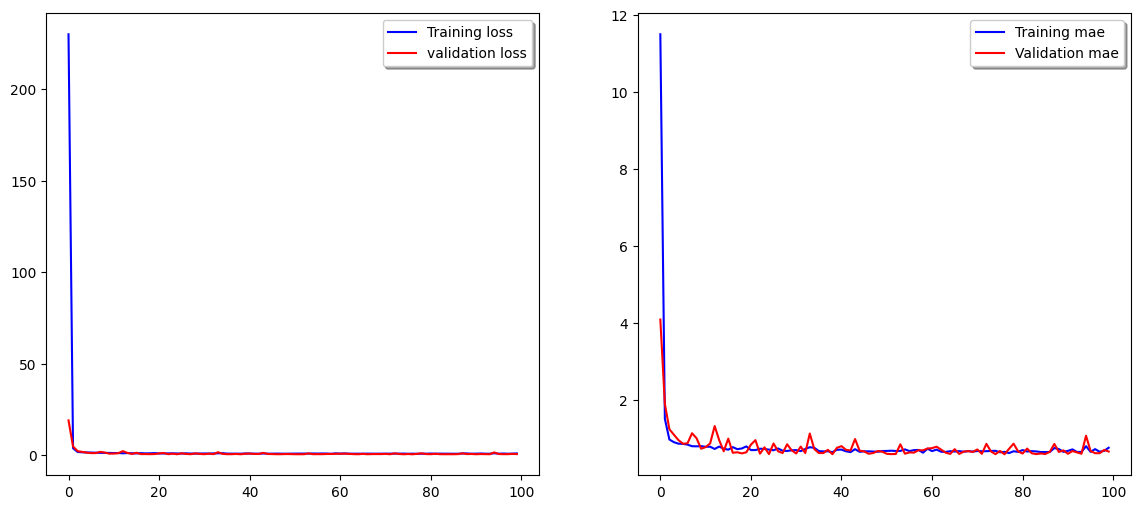

In [ ]:
grafico_history(history, "bb_lstm_5_5_history")

In [ ]:
# Previsão
bb_lstm_5_5_previsao = prever_x_dias(bb_teste_5_x, bb_lstm_5_5)

1/1 [==============================] - 0s 23ms/step


In [ ]:
bb_teste_5_y, bb_lstm_5_5_previsao

(array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([48.08792 , 47.828487, 47.57356 , 47.39701 , 47.253414],
       dtype=float32))

#### Dados com pre-processamento

##### Usar 5 dias para prever 5 dias

In [ ]:
# Carregar o modelo completo a partir do arquivo
bb_lstm_5_5_diff = load_model('bb_lstm_5_5_diff.h5')

# Carregar os detalhes
with open('bb_lstm_5_5_diff.json', 'r') as file:
    detalhes_treinamento = json.load(file)

# Acessar os detalhes
print('Épocas:', detalhes_treinamento['epocas'])
print('Batch Size:', detalhes_treinamento['batch_size'])
print('Otimizador:', detalhes_treinamento['otimizador'])

In [ ]:
# Criação do modelo
bb_lstm_5_5_diff = Sequential()

# adicionando as camadas ocultas
bb_lstm_5_5_diff.add(LSTM(units=80, activation='selu', input_shape=(5, 1), return_sequences=True))

bb_lstm_5_5_diff.add(LSTM(units=80, activation='selu', return_sequences=True))

bb_lstm_5_5_diff.add(LSTM(units=80, activation='selu', return_sequences=True))

bb_lstm_5_5_diff.add(LSTM(units=80, activation='selu', return_sequences=False))

# Camada de saída
bb_lstm_5_5_diff.add(Dense(units=1))

# Compilar o modelo
bb_lstm_5_5_diff.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Treinamento do modelo
history = bb_lstm_5_5_diff.fit(bb_treino_5_x_diff, bb_treino_5_y_diff, epochs=130, batch_size=28,
                               validation_data=(bb_val_5_x_diff, bb_val_5_y_diff))

Epoch 1/130
25/25 [==============================] - 6s 51ms/step - loss: 0.8985 - mae: 0.6218 - val_loss: 0.5593 - val_mae: 0.5794
Epoch 2/130
25/25 [==============================] - 0s 19ms/step - loss: 0.8865 - mae: 0.6198 - val_loss: 0.5633 - val_mae: 0.5828
Epoch 3/130
25/25 [==============================] - 0s 19ms/step - loss: 0.8905 - mae: 0.6311 - val_loss: 0.5465 - val_mae: 0.5723
Epoch 4/130
25/25 [==============================] - 0s 19ms/step - loss: 0.8944 - mae: 0.6183 - val_loss: 0.5500 - val_mae: 0.5740
Epoch 5/130
25/25 [==============================] - 0s 19ms/step - loss: 0.8882 - mae: 0.6174 - val_loss: 0.5515 - val_mae: 0.5747
Epoch 6/130
25/25 [==============================] - 0s 19ms/step - loss: 0.8850 - mae: 0.6167 - val_loss: 0.5553 - val_mae: 0.5768
Epoch 7/130
25/25 [==============================] - 1s 20ms/step - loss: 0.8861 - mae: 0.6184 - val_loss: 0.5545 - val_mae: 0.5761
Epoch 8/130
25/25 [==============================] - 1s 27ms/step - loss: 0.

In [ ]:
# Salvar o modelo para não perder os resultados
#bb_lstm_5_5_diff.save('bb_lstm_5_5_diff.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Salvar detalhes separadamente
detalhes_treinamento = {
    'epocas': 150,
    'batch_size': 32,
    'otimizador': 'adam',
    'activation': 'relu'
}

with open('bb_lstm_5_5_diff.json', 'w') as file:
    json.dump(detalhes_treinamento, file)

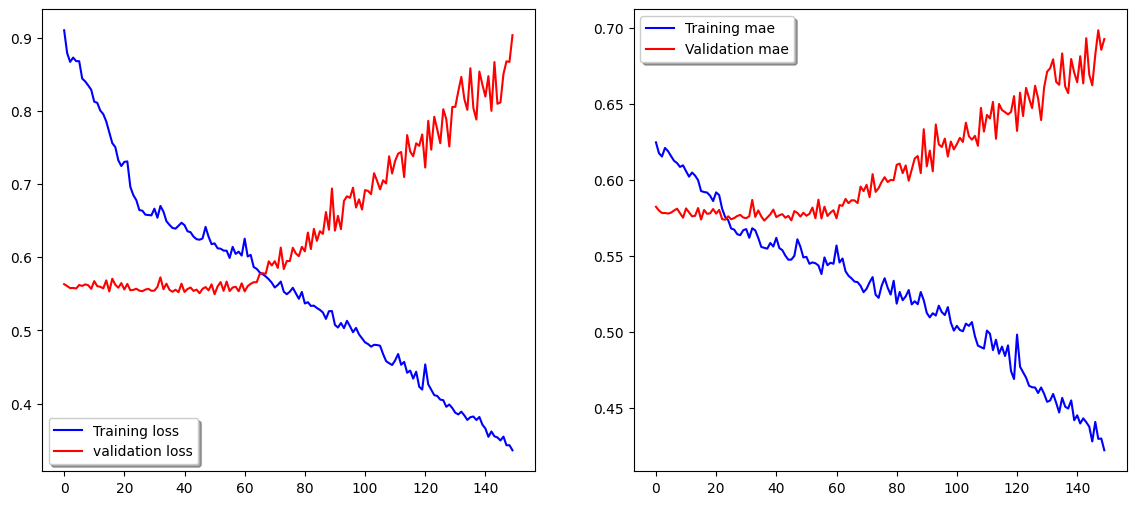

In [ ]:
grafico_history(history, "bb_lstm_5_5_diff_history")

In [ ]:
# Faz a previsão e logo em seguida é feito a reversão da diferenciação
bb_lstm_5_5_previsao_diff = prever_x_dias(bb_teste_5_x_diff, bb_lstm_5_5_diff)
bb_lstm_5_5_previsao_diff = diff_reverse(bb_lstm_5_5_previsao_diff, bb_referencia)[1:]

1/1 [==============================] - 0s 27ms/step


In [ ]:
bb_teste_5_y, bb_lstm_5_5_previsao_diff

(array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([48.3891129 , 49.0615306 , 48.6845528 , 48.51491179, 48.53037689]))

In [ ]:
bb_teste_5_y, diff_reverse(bb_teste_5_y_diff, bb_referencia)[1:]

(array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]))

## 3.6. GRU

### BB

#### Dados sem pre-processamento

##### Usar 5 dias para prever 5 dias

In [ ]:
# Carregar o modelo completo a partir do arquivo
bb_gru_5_5 = load_model('bb_gru_5_5.h5')

# Carregar os detalhes
with open('bb_gru_5_5.json', 'r') as file:
    detalhes_treinamento = json.load(file)

# Acessar os detalhes
print('Épocas:', detalhes_treinamento['epocas'])
print('Batch Size:', detalhes_treinamento['batch_size'])
print('Otimizador:', detalhes_treinamento['otimizador'])

In [ ]:
# Criação do modelo
bb_gru_5_5 = Sequential()

# adicionando as camadas ocultas
bb_gru_5_5.add(GRU(units=60, activation='relu', input_shape=(5, 1), return_sequences=False))

#bb_gru_5_5.add(GRU(units=60, activation='relu', return_sequences=True))

# Camada de saída
bb_gru_5_5.add(Dense(units=1))

# Compilar o modelo
bb_gru_5_5.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Treinamento do modelo
history = bb_gru_5_5.fit(bb_treino_5_x, bb_treino_5_y, epochs=80, batch_size=20, validation_data=(bb_val_5_x, bb_val_5_y))

Epoch 1/80
35/35 [==============================] - 3s 17ms/step - loss: 275.9290 - mae: 12.3566 - val_loss: 2.7123 - val_mae: 1.3034
Epoch 2/80
35/35 [==============================] - 0s 6ms/step - loss: 3.6645 - mae: 1.5067 - val_loss: 3.1430 - val_mae: 1.4593
Epoch 3/80
35/35 [==============================] - 0s 6ms/step - loss: 1.5424 - mae: 0.8798 - val_loss: 1.8814 - val_mae: 1.1028
Epoch 4/80
35/35 [==============================] - 0s 6ms/step - loss: 1.3980 - mae: 0.8270 - val_loss: 1.4821 - val_mae: 0.9631
Epoch 5/80
35/35 [==============================] - 0s 6ms/step - loss: 1.3612 - mae: 0.8090 - val_loss: 2.0041 - val_mae: 1.1644
Epoch 6/80
35/35 [==============================] - 0s 8ms/step - loss: 1.4070 - mae: 0.8354 - val_loss: 1.9594 - val_mae: 1.1527
Epoch 7/80
35/35 [==============================] - 0s 5ms/step - loss: 1.2948 - mae: 0.7907 - val_loss: 1.6848 - val_mae: 1.0560
Epoch 8/80
35/35 [==============================] - 0s 6ms/step - loss: 1.2667 - mae: 

In [ ]:
# Salvar o modelo para não perder os resultados
#bb_gru_5_5.save('bb_gru_5_5.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Salvar detalhes separadamente
detalhes_treinamento = {
    'epocas': 80,
    'batch_size': 20,
    'otimizador': 'adam',
    'activation': 'relu'
}

with open('bb_gru_5_5.json', 'w') as file:
    json.dump(detalhes_treinamento, file)

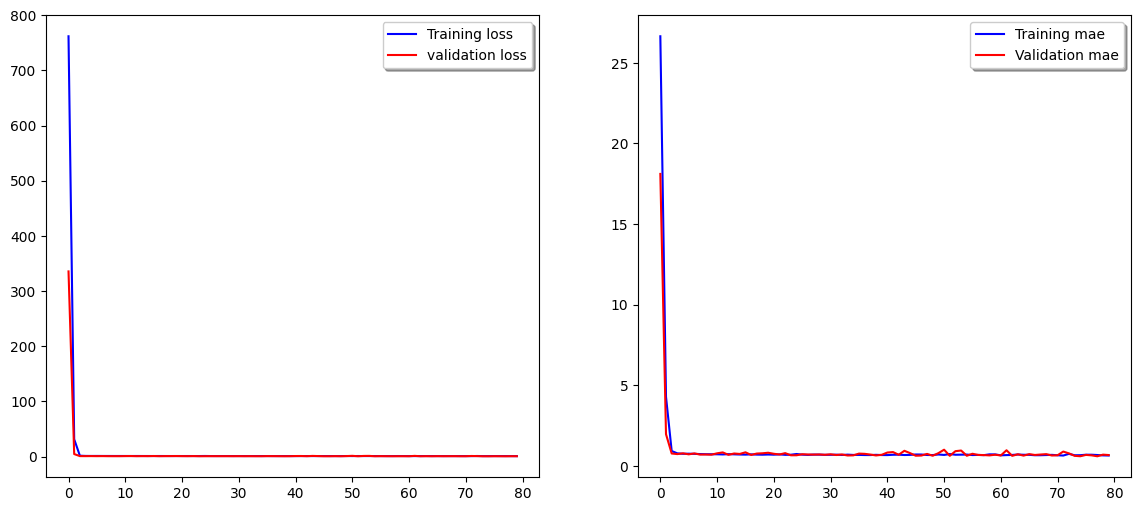

In [ ]:
grafico_history(history, "bb_gru_5_5_history")

In [ ]:
# Previsão
bb_gru_5_5_previsao = prever_x_dias(bb_teste_5_x, bb_gru_5_5)

1/1 [==============================] - 0s 16ms/step


In [ ]:
bb_teste_5_y, bb_gru_5_5_previsao

(array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([48.43447 , 48.444866, 48.42331 , 48.411446, 48.395523],
       dtype=float32))

#### Dados com pre-processamento

##### Usar 5 dias para prever 5 dias

In [ ]:
# Carregar o modelo completo a partir do arquivo
bb_gru_5_5_diff = load_model('bb_gru_5_5_diff.h5')

# Carregar os detalhes
with open('bb_gru_5_5_diff.json', 'r') as file:
    detalhes_treinamento = json.load(file)

# Acessar os detalhes
print('Épocas:', detalhes_treinamento['epocas'])
print('Batch Size:', detalhes_treinamento['batch_size'])
print('Otimizador:', detalhes_treinamento['otimizador'])
print('Ativação:', detalhes_treinamento['activation'])

Épocas: 130
Batch Size: 20
Otimizador: adam
Ativação: 3 camadas linear


In [ ]:
# Criação do modelo
bb_gru_5_5_diff = Sequential()

# adicionando as camadas ocultas
bb_gru_5_5_diff.add(GRU(units=100, activation='elu', input_shape=(5, 1), return_sequences=True))

bb_gru_5_5_diff.add(GRU(units=100, activation='linear', return_sequences=True))

bb_gru_5_5_diff.add(GRU(units=100, activation='linear', return_sequences=False))

# Camada de saída
bb_gru_5_5_diff.add(Dense(units=1))

# Compilar o modelo
bb_gru_5_5_diff.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Treinamento do modelo
history = bb_gru_5_5_diff.fit(bb_treino_5_x_diff, bb_treino_5_y_diff, epochs=130, batch_size=32, validation_data=(bb_val_5_x_diff, bb_val_5_y_diff))

Epoch 1/130
22/22 [==============================] - 7s 43ms/step - loss: 0.9009 - mae: 0.6207 - val_loss: 0.5474 - val_mae: 0.5737
Epoch 2/130
22/22 [==============================] - 0s 16ms/step - loss: 0.8855 - mae: 0.6171 - val_loss: 0.5555 - val_mae: 0.5783
Epoch 3/130
22/22 [==============================] - 0s 17ms/step - loss: 0.8735 - mae: 0.6166 - val_loss: 0.5740 - val_mae: 0.5898
Epoch 4/130
22/22 [==============================] - 0s 16ms/step - loss: 0.8677 - mae: 0.6203 - val_loss: 0.5555 - val_mae: 0.5808
Epoch 5/130
22/22 [==============================] - 0s 16ms/step - loss: 0.8802 - mae: 0.6255 - val_loss: 0.5631 - val_mae: 0.5825
Epoch 6/130
22/22 [==============================] - 0s 17ms/step - loss: 0.8616 - mae: 0.6177 - val_loss: 0.5788 - val_mae: 0.5884
Epoch 7/130
22/22 [==============================] - 0s 16ms/step - loss: 0.8589 - mae: 0.6196 - val_loss: 0.5578 - val_mae: 0.5784
Epoch 8/130
22/22 [==============================] - 0s 19ms/step - loss: 0.

In [ ]:
# Salvar o modelo para não perder os resultados
#bb_gru_5_5_diff.save('bb_gru_5_5_diff.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Salvar detalhes separadamente
detalhes_treinamento = {
    'epocas': 130,
    'batch_size': 32,
    'otimizador': 'adam',
    'activation': '3 camadas linear'
}

with open('bb_gru_5_5_diff.json', 'w') as file:
    json.dump(detalhes_treinamento, file)

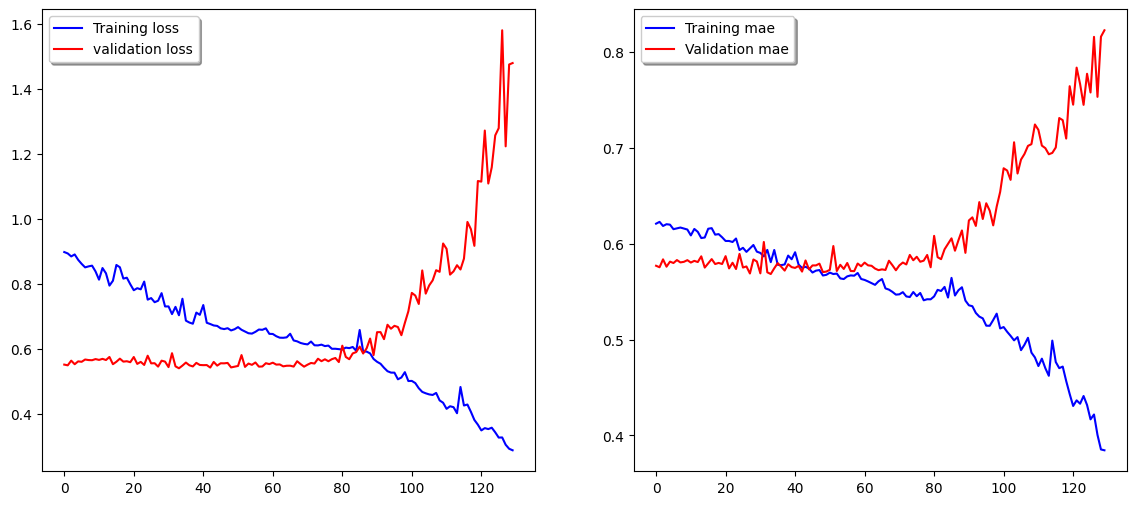

In [ ]:
grafico_history(history, "bb_gru_5_5_diff_history")

In [ ]:
# Faz a previsão e logo em seguida é feito a reversão da diferenciação
bb_gru_5_5_previsao_diff = prever_x_dias(bb_teste_5_x_diff, bb_gru_5_5_diff)
bb_gru_5_5_previsao_diff = diff_reverse(bb_gru_5_5_previsao_diff, bb_referencia)[1:]

1/1 [==============================] - 0s 25ms/step


In [ ]:
bb_teste_5_y, bb_gru_5_5_previsao_diff

(array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([48.25452885, 48.61543098, 48.54241604, 48.41485576, 48.66288222]))

In [ ]:
bb_teste_5_y, diff_reverse(bb_teste_5_y_diff, bb_referencia)[1:]

(array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]))

## 3.7. Transformers

### BB

#### Dados sem pre-processamento

##### Usar 5 dias para prever 5 dias

In [ ]:
# Carregar o modelo completo a partir do arquivo
bb_transformer_5_5 = load_model('bb_transformer_5_5.h5')

# Carregar os detalhes
with open('bb_transformer_5_5.json', 'r') as file:
    detalhes_treinamento = json.load(file)

# Acessar os detalhes
print('Épocas:', detalhes_treinamento['epocas'])
print('Batch Size:', detalhes_treinamento['batch_size'])
print('Otimizador:', detalhes_treinamento['otimizador'])

Épocas: 65
Batch Size: 32
Otimizador: adam


In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0, attention_axes=None):
  """
  inputs: As entradas para o bloco do transformador.
  head_size: A dimensão das cabeças de atenção.
  num_heads: O número de cabeças de atenção.
  ff_dim: A dimensão da camada de feedforward.
  dropout: A taxa de dropout para aplicar durante o treinamento.
  attention_axes: Os eixos ao longo dos quais a atenção deve ser aplicada.
  """

  # Aplica normalização de camada às entradas. Isso ajuda a estabilizar e acelerar o treinamento.
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)

  # Aplica atenção de múltiplas cabeças às entradas normalizadas.
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)

  # Aplica dropout à saída da atenção para evitar overfitting durante o treinamento.
  x = layers.Dropout(dropout)(x)

  # Adiciona a saída da atenção à entrada original, criando uma conexão residual.
  res = x + inputs

   # Feed Forward Part
  # Aplica normalização de camada à saída da conexão residual.
  x = layers.LayerNormalization(epsilon=1e-6)(res)

  # Aplica uma camada de convolução 1D com ativação ReLU.
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)

  # Aplica dropout à saída da camada de convolução.
  x = layers.Dropout(dropout)(x)

  # Aplica outra camada de convolução 1D.
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

  # Adiciona a saída da parte de feedforward à saída da conexão residual.
  return x + res

In [ ]:
def build_transfromer(head_size,
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units, dropout=0, mlp_dropout=0) -> Model:
  """
  head_size: Dimensão das cabeças de atenção.
  num_heads: Número de cabeças de atenção.
  ff_dim: Dimensão da camada de feedforward.
  num_trans_blocks: Número de blocos de transformadores a serem empilhados.
  mlp_units: Lista que especifica as dimensões das camadas totalmente conectadas na parte final do modelo.
  dropout: Taxa de dropout para ser aplicada nos blocos de transformadores.
  mlp_dropout: Taxa de dropout a ser aplicada nas camadas totalmente conectadas.
  """


  n_timesteps, n_features, n_outputs = 5, 1, 1      # nº de dias, nº de características, nº de saídas
  inputs = Input(shape=(n_timesteps, n_features))   # Dimensão dos dados de entrada

  #  Inicializa x com as entradas do modelo
  x = inputs

  # Empilha o número especificado de blocos de transformadores
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

  # Aplica uma redução dimensional global à saída dos blocos de transformadores.
  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

  # Adiciona camadas totalmente conectadas
  for dim in mlp_units:
    x = layers.Dense(dim, activation="selu")(x)

    # Aplica dropout nas saídas das camadas totalmente conectadas.
    x = layers.Dropout(mlp_dropout)(x)

  # Adiciona uma camada totalmente conectada de saída com ativação ReLU.
  outputs = layers.Dense(n_outputs, activation='selu')(x)

  # Retorna o modelo Keras completo, com as camadas definidas.
  return Model(inputs, outputs)

In [ ]:
bb_transformer_5_5 = build_transfromer(head_size=128, num_heads=4, ff_dim=2,
                                num_trans_blocks=4, mlp_units=[200],
                                mlp_dropout=0.2, dropout=0.2)

bb_transformer_5_5.compile(
    loss="mse",
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=["mae"],
)

history = bb_transformer_5_5.fit(bb_treino_5_x, bb_treino_5_y, batch_size=24,
                         epochs=65, validation_data=(bb_val_5_x, bb_val_5_y))

Epoch 1/65
30/30 [==============================] - 10s 64ms/step - loss: 459.2666 - mae: 17.4772 - val_loss: 23.7475 - val_mae: 4.7227
Epoch 2/65
30/30 [==============================] - 1s 25ms/step - loss: 35.2127 - mae: 4.6867 - val_loss: 3.6082 - val_mae: 1.6110
Epoch 3/65
30/30 [==============================] - 1s 25ms/step - loss: 27.7588 - mae: 4.0953 - val_loss: 2.4823 - val_mae: 1.2714
Epoch 4/65
30/30 [==============================] - 1s 24ms/step - loss: 25.9971 - mae: 4.0175 - val_loss: 2.7311 - val_mae: 1.3489
Epoch 5/65
30/30 [==============================] - 1s 27ms/step - loss: 24.4404 - mae: 3.8453 - val_loss: 2.9571 - val_mae: 1.4226
Epoch 6/65
30/30 [==============================] - 1s 25ms/step - loss: 23.2663 - mae: 3.6935 - val_loss: 1.5357 - val_mae: 0.9615
Epoch 7/65
30/30 [==============================] - 1s 25ms/step - loss: 18.4339 - mae: 3.3638 - val_loss: 1.5777 - val_mae: 0.9811
Epoch 8/65
30/30 [==============================] - 1s 25ms/step - loss:

In [ ]:
# Salvar o modelo para não perder os resultados
#bb_transformer_5_5.save('bb_transformer_5_5.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Salvar detalhes separadamente
detalhes_treinamento = {
    'epocas': 65,
    'batch_size': 32,
    'otimizador': 'adam'
}

with open('bb_transformer_5_5.json', 'w') as file:
    json.dump(detalhes_treinamento, file)

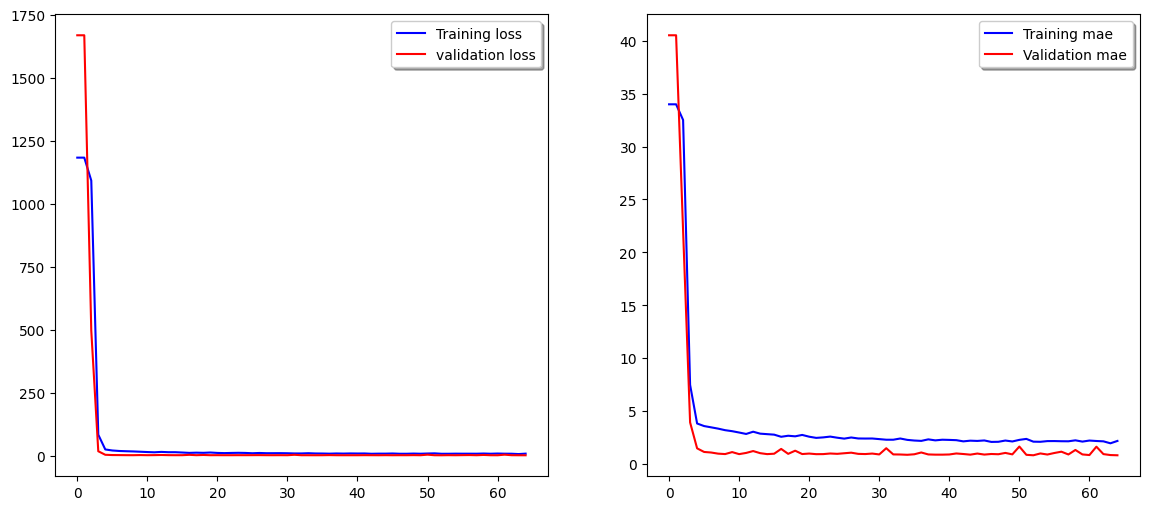

In [ ]:
grafico_history(history, "bb_transformer_5_5_history")

In [ ]:
# Previsão
bb_transformer_5_5_previsao = prever_x_dias(bb_teste_5_x, bb_transformer_5_5)

1/1 [==============================] - 0s 21ms/step


In [ ]:
bb_teste_5_y, bb_transformer_5_5_previsao

(array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([47.605095, 47.404987, 47.188602, 46.836533, 46.57177 ],
       dtype=float32))

#### Dados com pre-processamento

##### Usar 5 dias para prever 5 dias

In [ ]:
# Carregar o modelo completo a partir do arquivo
bb_transformer_5_5_diff = load_model('bb_transformer_5_5_diff.h5')

# Carregar os detalhes
with open('bb_transformer_5_5_diff.json', 'r') as file:
    detalhes_treinamento = json.load(file)

# Acessar os detalhes
print('Épocas:', detalhes_treinamento['epocas'])
print('Batch Size:', detalhes_treinamento['batch_size'])
print('Otimizador:', detalhes_treinamento['otimizador'])

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0, attention_axes=None):
  """
  inputs: As entradas para o bloco do transformador.
  head_size: A dimensão das cabeças de atenção.
  num_heads: O número de cabeças de atenção.
  ff_dim: A dimensão da camada de feedforward.
  dropout: A taxa de dropout para aplicar durante o treinamento.
  attention_axes: Os eixos ao longo dos quais a atenção deve ser aplicada.
  """

  # Aplica normalização de camada às entradas. Isso ajuda a estabilizar e acelerar o treinamento.
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)

  # Aplica atenção de múltiplas cabeças às entradas normalizadas.
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)

  # Aplica dropout à saída da atenção para evitar overfitting durante o treinamento.
  x = layers.Dropout(dropout)(x)

  # Adiciona a saída da atenção à entrada original, criando uma conexão residual.
  res = x + inputs

   # Feed Forward Part
  # Aplica normalização de camada à saída da conexão residual.
  x = layers.LayerNormalization(epsilon=1e-6)(res)

  # Aplica uma camada de convolução 1D com ativação ReLU.
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)

  # Aplica dropout à saída da camada de convolução.
  x = layers.Dropout(dropout)(x)

  # Aplica outra camada de convolução 1D.
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

  # Adiciona a saída da parte de feedforward à saída da conexão residual.
  return x + res

In [ ]:
def build_transfromer(head_size,
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units, dropout=0, mlp_dropout=0) -> Model:
  """
  head_size: Dimensão das cabeças de atenção.
  num_heads: Número de cabeças de atenção.
  ff_dim: Dimensão da camada de feedforward.
  num_trans_blocks: Número de blocos de transformadores a serem empilhados.
  mlp_units: Lista que especifica as dimensões das camadas totalmente conectadas na parte final do modelo.
  dropout: Taxa de dropout para ser aplicada nos blocos de transformadores.
  mlp_dropout: Taxa de dropout a ser aplicada nas camadas totalmente conectadas.
  """


  n_timesteps, n_features, n_outputs = 5, 1, 1      # nº de dias, nº de características, nº de saídas
  inputs = Input(shape=(n_timesteps, n_features))   # Dimensão dos dados de entrada

  #  Inicializa x com as entradas do modelo
  x = inputs

  # Empilha o número especificado de blocos de transformadores
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

  # Aplica uma redução dimensional global à saída dos blocos de transformadores.
  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

  # Adiciona camadas totalmente conectadas
  for dim in mlp_units:
    x = layers.Dense(dim, activation="selu")(x)

    # Aplica dropout nas saídas das camadas totalmente conectadas.
    x = layers.Dropout(mlp_dropout)(x)

  # Adiciona uma camada totalmente conectada de saída com ativação ReLU.
  outputs = layers.Dense(n_outputs, activation='selu')(x)

  # Retorna o modelo Keras completo, com as camadas definidas.
  return Model(inputs, outputs)

In [ ]:
bb_transformer_5_5_diff = build_transfromer(head_size=128, num_heads=4, ff_dim=2,
                                num_trans_blocks=4, mlp_units=[150],
                                mlp_dropout=0.1, dropout=0.1)

bb_transformer_5_5_diff.compile(
    loss="mse",
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=["mae"],
)

history = bb_transformer_5_5_diff.fit(bb_treino_5_x_diff, bb_treino_5_y_diff, batch_size=32,
                         epochs=70, validation_data=(bb_val_5_x_diff, bb_val_5_y_diff))

Epoch 1/70
22/22 [==============================] - 11s 84ms/step - loss: 0.9384 - mae: 0.6387 - val_loss: 0.5851 - val_mae: 0.5941
Epoch 2/70
22/22 [==============================] - 1s 41ms/step - loss: 0.9151 - mae: 0.6365 - val_loss: 0.5688 - val_mae: 0.5857
Epoch 3/70
22/22 [==============================] - 1s 29ms/step - loss: 0.9132 - mae: 0.6366 - val_loss: 0.5849 - val_mae: 0.5954
Epoch 4/70
22/22 [==============================] - 1s 28ms/step - loss: 0.9037 - mae: 0.6328 - val_loss: 0.5867 - val_mae: 0.5921
Epoch 5/70
22/22 [==============================] - 1s 29ms/step - loss: 0.9208 - mae: 0.6423 - val_loss: 0.5935 - val_mae: 0.6003
Epoch 6/70
22/22 [==============================] - 1s 32ms/step - loss: 0.8978 - mae: 0.6324 - val_loss: 0.5664 - val_mae: 0.5831
Epoch 7/70
22/22 [==============================] - 1s 28ms/step - loss: 0.9249 - mae: 0.6361 - val_loss: 0.6083 - val_mae: 0.6137
Epoch 8/70
22/22 [==============================] - 1s 29ms/step - loss: 0.9129 - 

In [ ]:
# Salvar o modelo para não perder os resultados
#bb_transformer_5_5_diff.save('bb_transformer_5_5_diff.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Salvar detalhes separadamente
detalhes_treinamento = {
    'epocas': 55,
    'batch_size': 32,
    'otimizador': 'adam',
    'activation': 'linear'
}

with open('bb_transformer_5_5_diff.json', 'w') as file:
    json.dump(detalhes_treinamento, file)

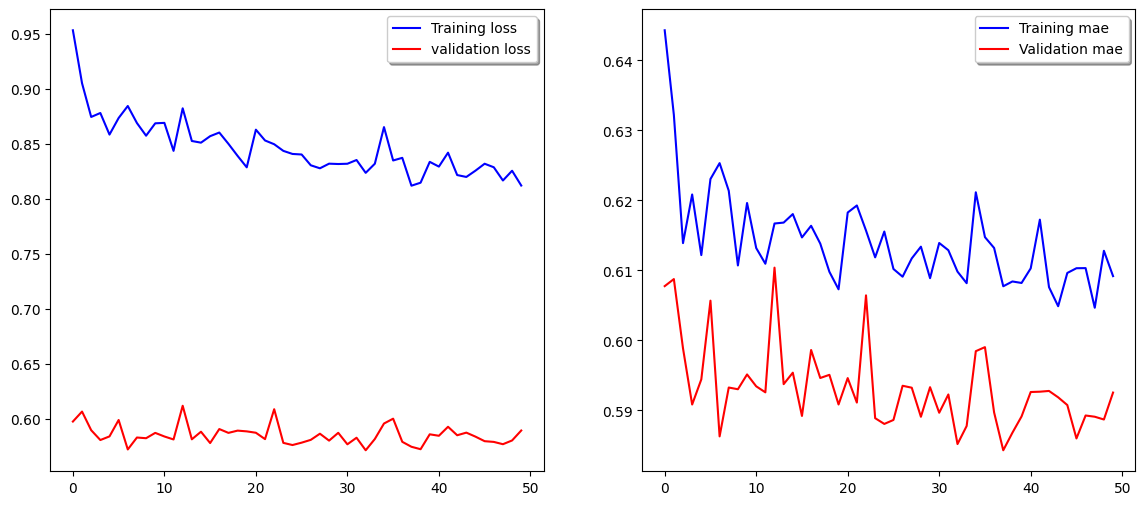

In [ ]:
grafico_history(history, "bb_transformer_5_5_diff_history")

In [ ]:
# Faz a previsão e logo em seguida é feito a reversão da diferenciação
bb_transformer_5_5_previsao_diff = prever_x_dias(bb_teste_5_x_diff, bb_transformer_5_5_diff)
bb_transformer_5_5_previsao_diff = diff_reverse(bb_transformer_5_5_previsao_diff, bb_referencia)[1:]

1/1 [==============================] - 0s 24ms/step


In [ ]:
bb_teste_5_y, bb_transformer_5_5_previsao_diff

(array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([48.53565289, 48.60076969, 48.61978405, 48.62101692, 48.68316161]))

In [ ]:
bb_teste_5_y, diff_reverse(bb_teste_5_y_diff, bb_referencia)[1:]

(array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]),
 array([47.56999969, 47.31999969, 47.72000122, 46.74000168, 47.27999878]))

# 4. Avaliação

## Funções

In [ ]:
# Função para avaliar o erro
def avaliar_modelo(data_test, forecast):
  """
  data_test: Os dados originais
  forecast: Os dados de previsão
  """

  MSE = mean_squared_error(data_test, forecast)
  RMSE = np.sqrt(MSE)
  MAE = mean_absolute_error(data_test, forecast)
  MAPE = mean_absolute_percentage_error(data_test, forecast) * 100
  R_2 = r2_score(data_test, forecast) * 100

  print(f'MSE: {MSE:0.3f}')
  print(f'RMSE: {RMSE:0.3f}')
  print(f'MAE: {MAE:0.3f}')
  print(f'MAPE: {MAPE:0.3f}%')
  print(f'R²: {R_2:0.3f}%')

In [ ]:
# Função para plotar um gráfico
def plot_resultados(data_train, data_test, forecast, save=False, title_plot=' ', title=' ', figsize=(8,6)):
  """
  data_train: Dados de treino
  data_test: Dados de teste
  forecast: Dados de previsão
  save: Salvar o gráfico, por padrão é False
  title_plot: Caso o parâmetro save for igual a True então o title_plot será o nome do arquivo
  title: Título do gráfico, por padrão é um espaço vazio
  figsize: Tamanho da visualização, por padrão é (8,6)
  """

  # Cria o gráfico
  plt.figure(figsize=figsize)

  # Plotando os dados de treino
  plt.plot(np.arange(len(data_train)), data_train, label='Dados de treino')

  # Plotando os dados de teste e as previsões
  plt.plot(np.arange(len(data_train), len(data_train) + len(data_test)), data_test, label='Dados de teste')
  plt.plot(np.arange(len(data_train), len(data_train) + len(data_test)), forecast, label='Previsão')

  # Adiciona o título caso tenha
  if title != ' ':
    plt.title(title)

  # Legenda
  plt.legend()

  # Salva o gráfico
  if save == True:
    plt.savefig(title_plot)

  # Exibe o gráfico
  plt.show()

In [ ]:
def evolution_of_metrics(data_test, forecast):
    # Lista que armazena os valores das métricas
    MSE, RMSE, MAE, MAPE, R_2, pontos = [], [], [], [], [], []

    # Cria n pontos de cada métrica
    for i in range(2, len(data_test)+1):
        sep = i

        # Calcula os valores
        MSE.append(mean_squared_error(data_test[:sep], forecast[:sep]))
        RMSE.append(np.sqrt(mean_squared_error(data_test[:sep], forecast[:sep])))
        MAE.append(mean_absolute_error(data_test[:sep], forecast[:sep]))
        MAPE.append(mean_absolute_percentage_error(data_test[:sep], forecast[:sep]) * 100)
        R_2.append(r2_score(data_test[:sep], forecast[:sep]) * 100)
        pontos.append(sep)

    # Retorna as listas
    return MSE, RMSE, MAE, MAPE, R_2, pontos

In [ ]:
def plot_metrics(array_metrics, title=str):
    # 3 gráficos em um
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # 1º gráfico - RMSE
    ax[0].plot(np.array(array_metrics[-1]), np.array(array_metrics[1]), color='g', label="RMSE")
    ax[0].set_title('Root Mean Squared Error (RMSE)')
    ax[0].set_xlabel('Dias')
    ax[0].set_ylabel('Valor')
    ax[0].legend()

    # 2º gráfico - MAPE
    ax[1].plot(np.array(array_metrics[-1]), np.array(array_metrics[3]), color='c', label="MAPE")
    ax[1].set_title('Mean Absolute Percentage Error (MAPE)')
    ax[1].set_xlabel('Dia')
    ax[1].set_ylabel('Valor')
    ax[1].legend()

    # Remove o subplot não utilizado
    #fig.delaxes(ax[2, 1])

    # Ajusta o layout
    plt.tight_layout()

    # salva o gráfico
    plt.savefig(title)

    plt.show()

## SARIMA

### BB

#### Dados sem pre-processamento

##### Prever 5 dias

<p>Melhores resultados:<p>
<p>MSE: 1.694   <p>  
<p>RMSE: 1.301   <p>
<p>MAE: 1.258    <p>
<p>MAPE: 2.664% <p>
<p>R²: -1411.354%   <p>

In [ ]:
avaliar_modelo(bb_teste_5_y, bb_sarima_5_previsao)

MSE: 1.694
RMSE: 1.301
MAE: 1.258
MAPE: 2.664%
R²: -1411.354%


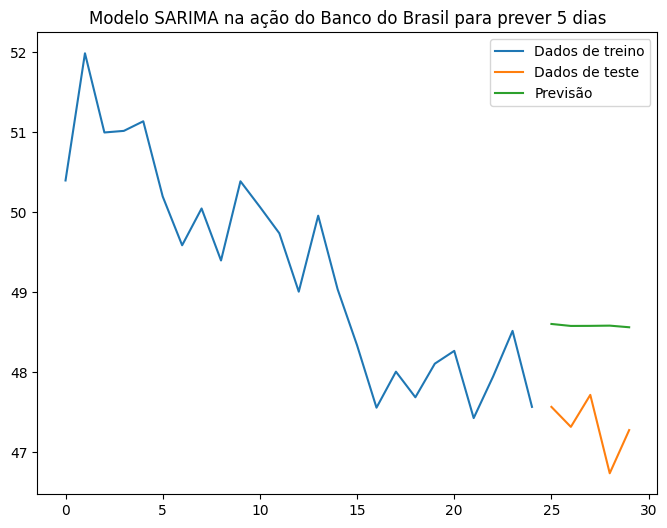

In [ ]:
plot_resultados(np.array(bb_close['Close'])[-30:-5], bb_teste_5_y, bb_sarima_5_previsao, save=True, title_plot='bb_sarima_5.png',
                title='Modelo SARIMA na ação do Banco do Brasil para prever 5 dias')

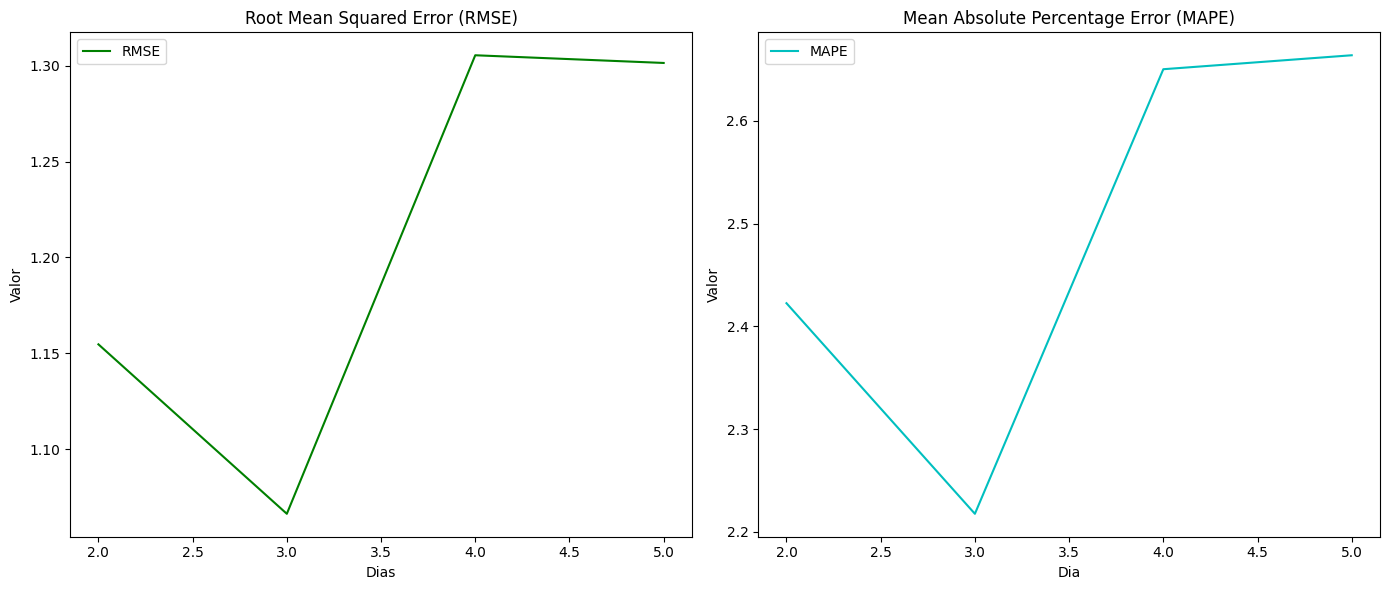

In [ ]:
plot_metrics(evolution_of_metrics(bb_teste_5_y, bb_sarima_5_previsao), title='bb_sarima_5_metrics')

##### Prever 10 dias

<p>Melhores resultados:<p>
<p>MSE: 0.252   <p>  
<p>RMSE: 0.502   <p>
<p>MAE: 0.402    <p>
<p>MAPE: 0.842% <p>
<p>R²: 1.513%   <p>

In [ ]:
avaliar_modelo(bb_teste_5_y, bb_sarima_10_previsao)

MSE: 0.252
RMSE: 0.502
MAE: 0.402
MAPE: 0.842%
R²: 1.513%


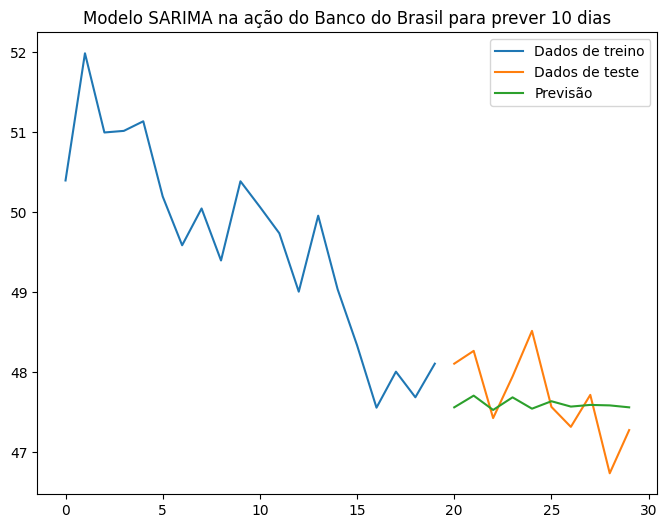

In [ ]:
plot_resultados(np.array(bb_close['Close'])[-30:-10], bb_teste_5_y, bb_sarima_10_previsao, save=True, title_plot='bb_sarima_10.png',
                title='Modelo SARIMA na ação do Banco do Brasil para prever 10 dias')

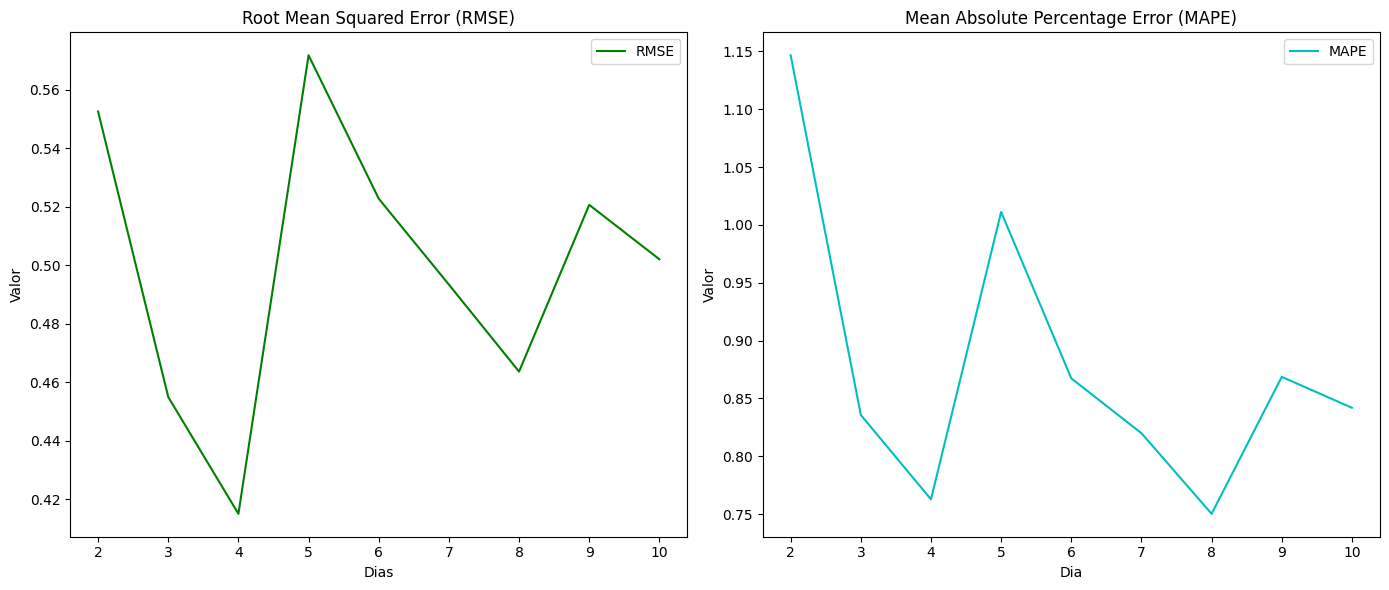

In [ ]:
plot_metrics(evolution_of_metrics(bb_teste_5_y, bb_sarima_10_previsao), title='bb_sarima_10_metrics')

#### Dados com pre-processamento

##### Prever 5 dias

<p>Melhores resultados:<p>
<p>MSE: 1.692   <p>  
<p>RMSE: 1.301   <p>
<p>MAE: 1.258    <p>
<p>MAPE: 2.662% <p>
<p>R²: -1409.715%   <p>

In [ ]:
avaliar_modelo(bb_teste_5_y, bb_sarima_5_previsao_diff)

MSE: 1.692
RMSE: 1.301
MAE: 1.258
MAPE: 2.662%
R²: -1409.715%


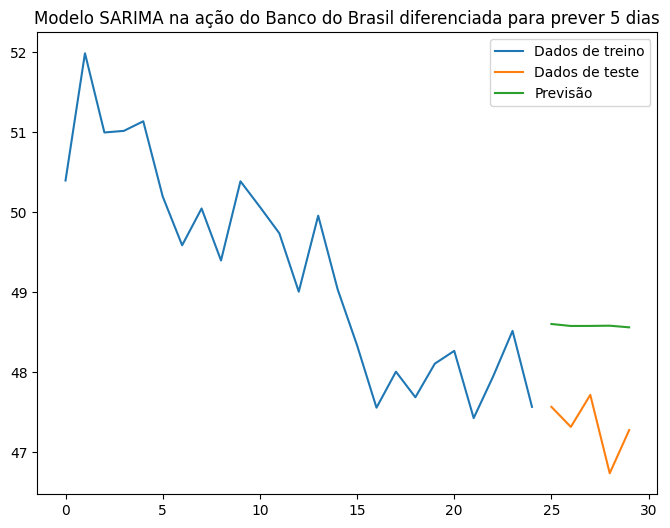

In [ ]:
plot_resultados(np.array(bb_close['Close'])[-30:-5], bb_teste_5_y, bb_sarima_5_previsao_diff, save=True, title_plot='bb_sarima_5_diff.png',
                title='Modelo SARIMA na ação do Banco do Brasil diferenciada para prever 5 dias')

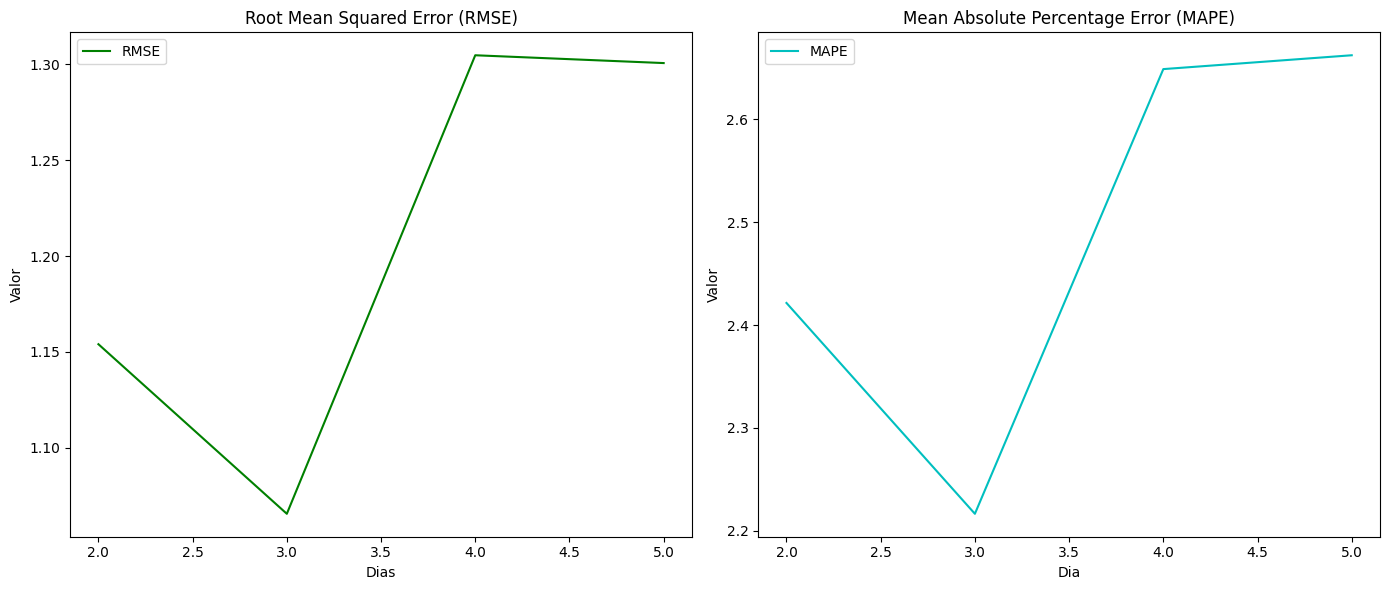

In [ ]:
plot_metrics(evolution_of_metrics(bb_teste_5_y, bb_sarima_5_previsao_diff), title='bb_sarima_5_diff_metrics')

##### Prever 10 dias

<p>Melhores resultados:<p>
<p>MSE: 0.252   <p>  
<p>RMSE: 0.502   <p>
<p>MAE: 0.402    <p>
<p>MAPE: 0.842% <p>
<p>R²: 1.513%   <p>

In [ ]:
avaliar_modelo(bb_teste_5_y, bb_sarima_10_previsao_diff)

MSE: 0.252
RMSE: 0.502
MAE: 0.402
MAPE: 0.842%
R²: 1.513%


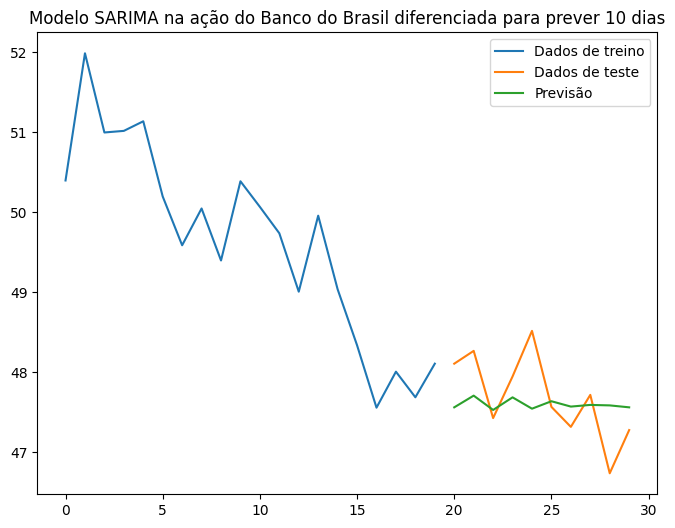

In [ ]:
plot_resultados(np.array(bb_close['Close'])[-30:-10], bb_teste_5_y, bb_sarima_10_previsao_diff, save=True, title_plot='bb_sarima_10_diff.png',
                title='Modelo SARIMA na ação do Banco do Brasil diferenciada para prever 10 dias')

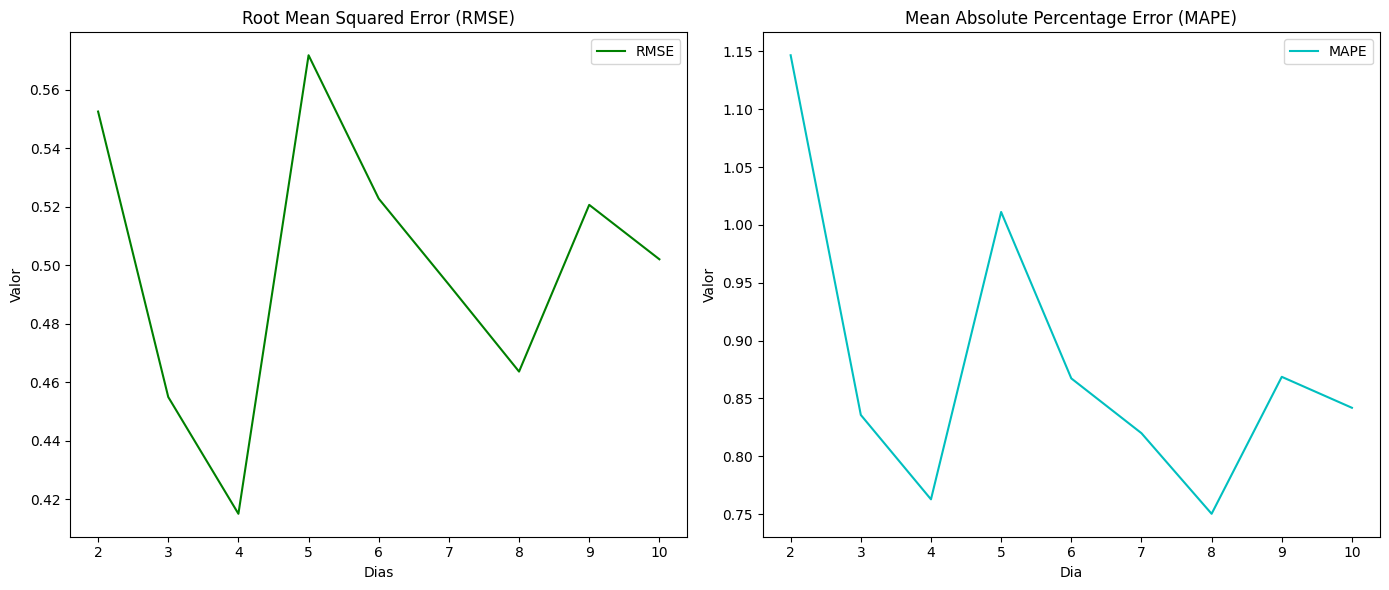

In [ ]:
plot_metrics(evolution_of_metrics(bb_teste_5_y, bb_sarima_10_previsao_diff), title='bb_sarima_10_diff_metrics')

## Holt-Winters

### BB

#### Dados sem pre-processamento

##### Prever 5 dias

<p>Melhores parâmetros: trend='add ,seasonal='mul', seasonal_periods=200<p>
<p>Melhores resultados:<p>
<p>MSE: 0.329   <p>  
<p>RMSE: 0.573   <p>
<p>MAE: 0.458    <p>
<p>MAPE: 0.966% <p>
<p>R²: -193.351%   <p>

In [ ]:
avaliar_modelo(bb_teste_5_y, bb_hw_5_previsao)

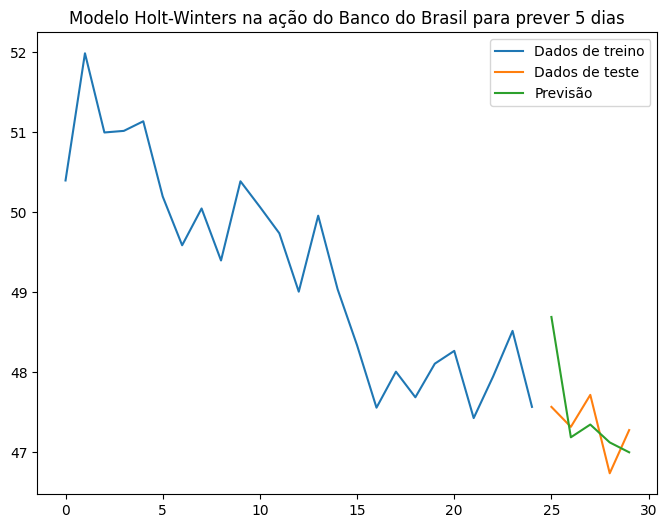

In [ ]:
plot_resultados(np.array(bb_close['Close'])[-30:-5], bb_teste_5_y, bb_hw_5_previsao, save=True, title_plot='bb_hw_5.png',
                title='Modelo Holt-Winters na ação do Banco do Brasil para prever 5 dias')

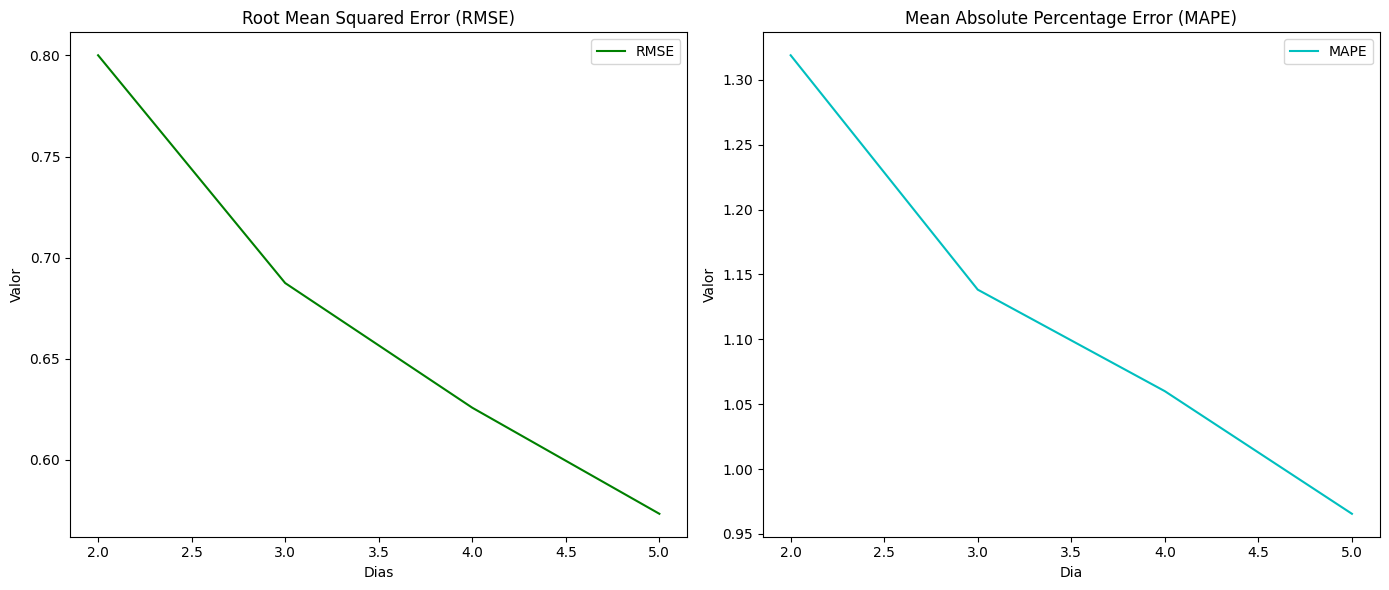

In [ ]:
plot_metrics(evolution_of_metrics(bb_teste_5_y, bb_hw_5_previsao), title='bb_hw_5_metrics')

##### Prever 10 dias

<p>Melhores parâmetros: trend='add ,seasonal='add', seasonal_periods=7<p>
<p>Melhores resultados:<p>
<p>MSE: 0.238   <p>  
<p>RMSE: 0.488   <p>
<p>MAE: 0.412    <p>
<p>MAPE: 0.863% <p>
<p>R²: 6.999%   <p>

In [ ]:
avaliar_modelo(bb_teste_5_y, bb_hw_10_previsao)

MSE: 0.238
RMSE: 0.488
MAE: 0.412
MAPE: 0.863%
R²: 6.999%


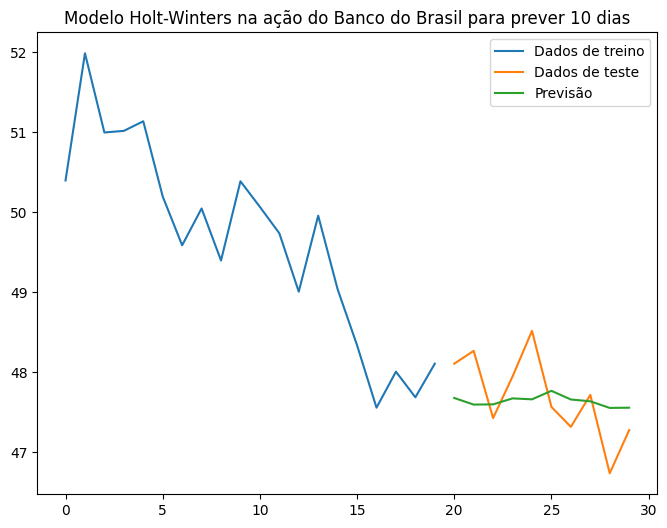

In [ ]:
plot_resultados(np.array(bb_close['Close'])[-30:-10], bb_teste_5_y, bb_hw_10_previsao, save=True, title_plot='bb_hw_10.png',
                title='Modelo Holt-Winters na ação do Banco do Brasil para prever 10 dias')

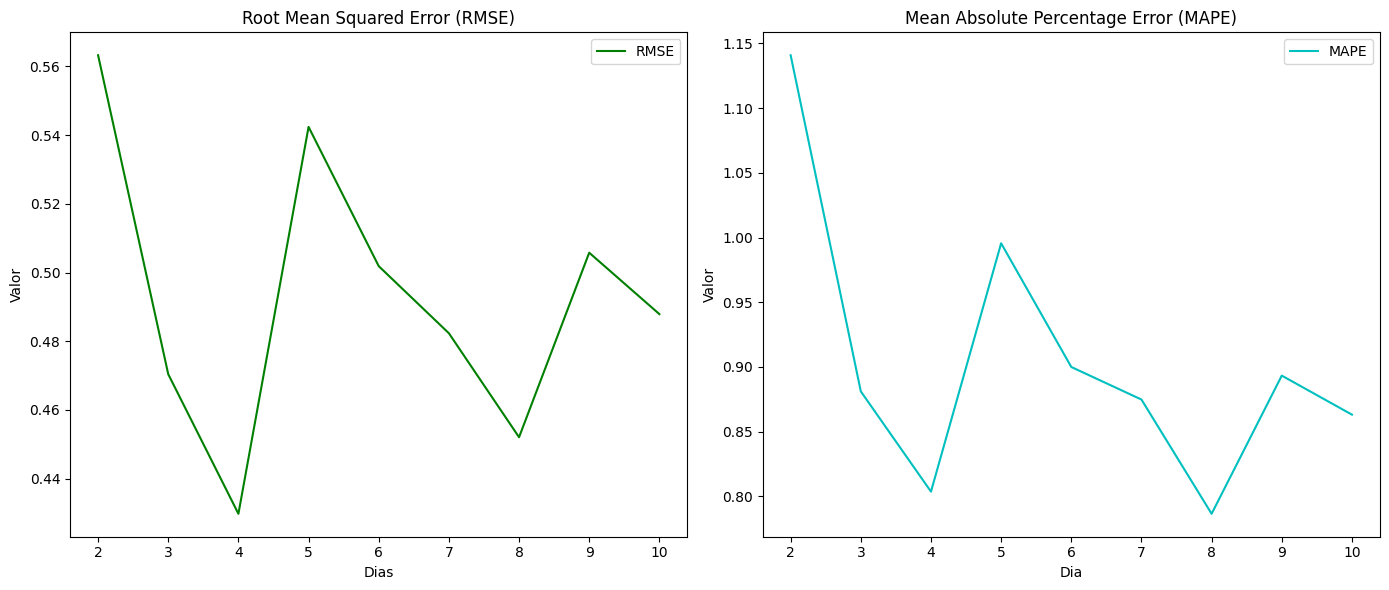

In [ ]:
plot_metrics(evolution_of_metrics(bb_teste_5_y, bb_hw_10_previsao), title='bb_hw_10_metrics')

#### Dados com pre-processamento

##### Prever 5 dias

<p>Melhores parâmetros: trend='add ,seasonal='add', seasonal_periods=220<p>
<p>Melhores resultados:<p>
<p>MSE: 0.355   <p>  
<p>RMSE: 0.596   <p>
<p>MAE: 0.464    <p>
<p>MAPE: 0.987% <p>
<p>R²: -216.664%   <p>

In [ ]:
avaliar_modelo(bb_teste_5_y, bb_hw_5_previsao_diff)

MSE: 0.355
RMSE: 0.596
MAE: 0.469
MAPE: 0.987%
R²: -216.664%


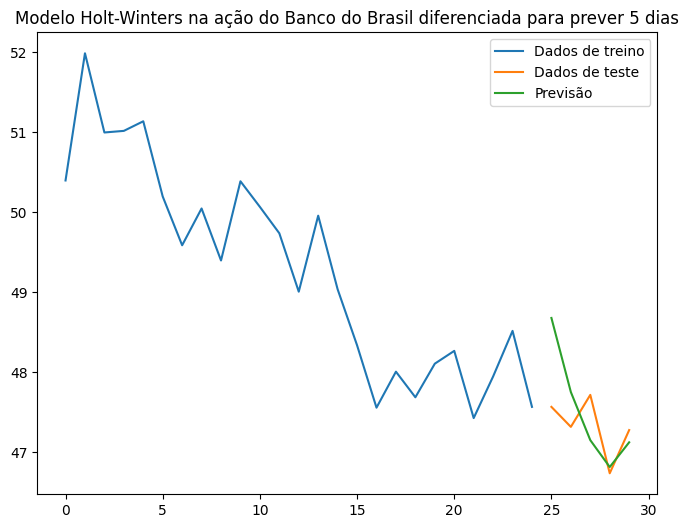

In [ ]:
plot_resultados(np.array(bb_close['Close'])[-30:-5], bb_teste_5_y, bb_hw_5_previsao_diff, save=True, title_plot='bb_hw_5_diff.png',
                title='Modelo Holt-Winters na ação do Banco do Brasil diferenciada para prever 5 dias')

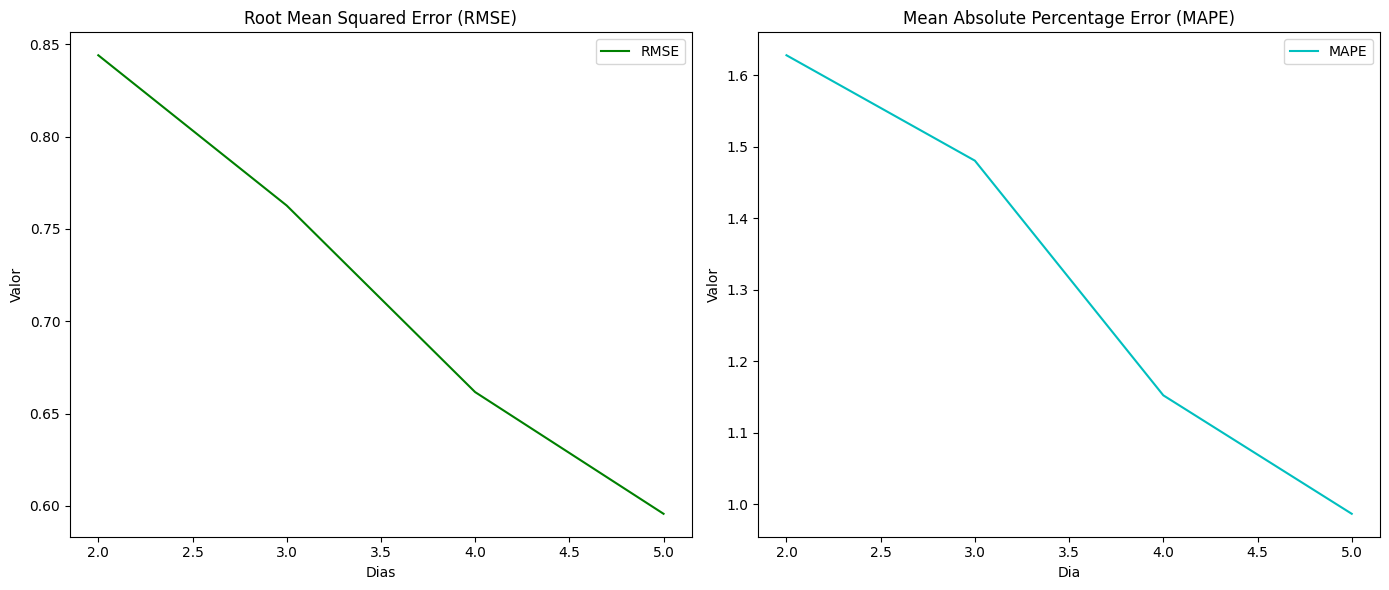

In [ ]:
plot_metrics(evolution_of_metrics(bb_teste_5_y, bb_hw_5_previsao_diff), title='bb_hw_5_diff_metrics')

##### Prever 10 dias

<p>Melhores parâmetros: trend='add ,seasonal='add', seasonal_periods=202<p>
<p>Melhores resultados:<p>
<p>MSE: 0.367   <p>  
<p>RMSE: 0.606   <p>
<p>MAE: 0.534    <p>
<p>MAPE: 1.122% <p>
<p>R²: -43.269%   <p>

In [ ]:
avaliar_modelo(bb_teste_5_y, bb_hw_10_previsao_diff)

MSE: 0.367
RMSE: 0.606
MAE: 0.534
MAPE: 1.122%
R²: -43.269%


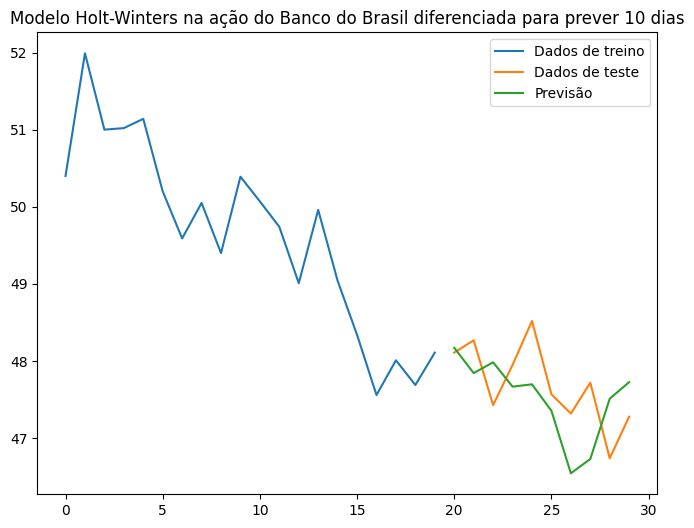

In [ ]:
plot_resultados(np.array(bb_close['Close'])[-30:-10], bb_teste_5_y, bb_hw_10_previsao_diff, save=True, title_plot='bb_hw_10_diff.png',
                title='Modelo Holt-Winters na ação do Banco do Brasil diferenciada para prever 10 dias')

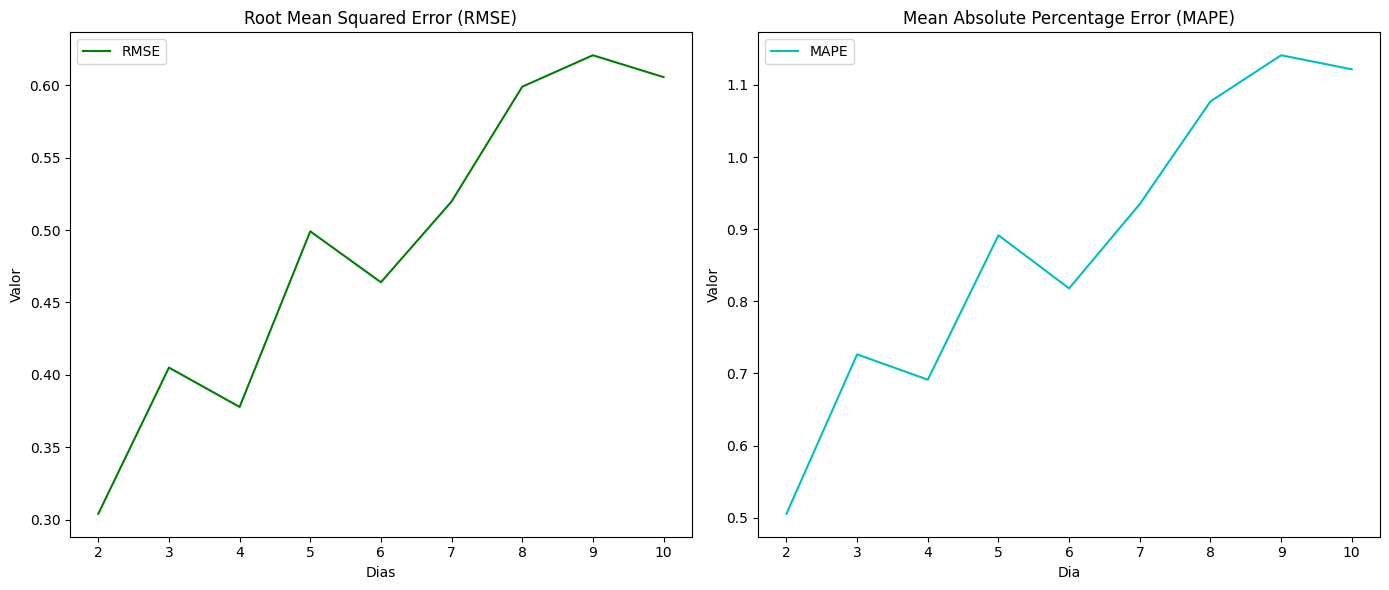

In [ ]:
plot_metrics(evolution_of_metrics(bb_teste_5_y, bb_hw_10_previsao_diff), title='bb_hw_10_diff_metrics')

## MLPs

### BB

#### Dados sem pre-processamento

##### Usar 5 dias para prever 5 dias

<p>Melhores resultados:<p>
<p>MSE: 0.138   <p>  
<p>RMSE: 0.371   <p>
<p>MAE: 0.352    <p>
<p>MAPE: 0.745% <p>
<p>R²: -22.928%   <p>

In [ ]:
avaliar_modelo(bb_teste_5_y, bb_mlp_5_5_previsao)

MSE: 0.138
RMSE: 0.371
MAE: 0.352
MAPE: 0.745%
R²: -22.928%


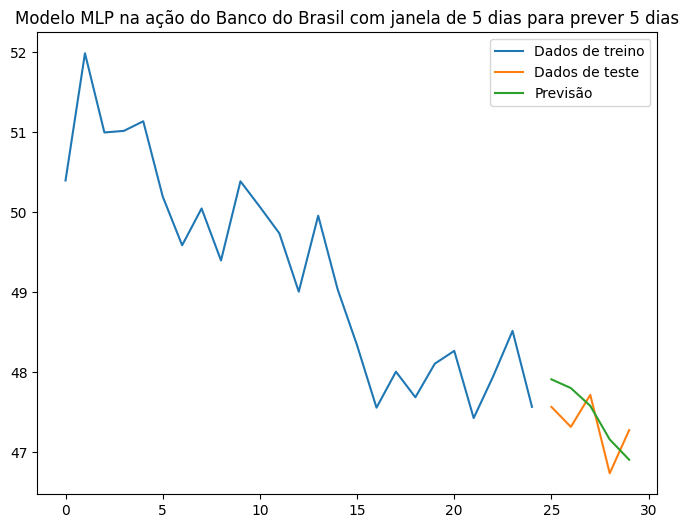

In [ ]:
plot_resultados(np.array(bb_close['Close'])[-30:-5], bb_teste_5_y, bb_mlp_5_5_previsao, save=True, title_plot='bb_mlp_5_5.png',
                title='Modelo MLP na ação do Banco do Brasil com janela de 5 dias para prever 5 dias')

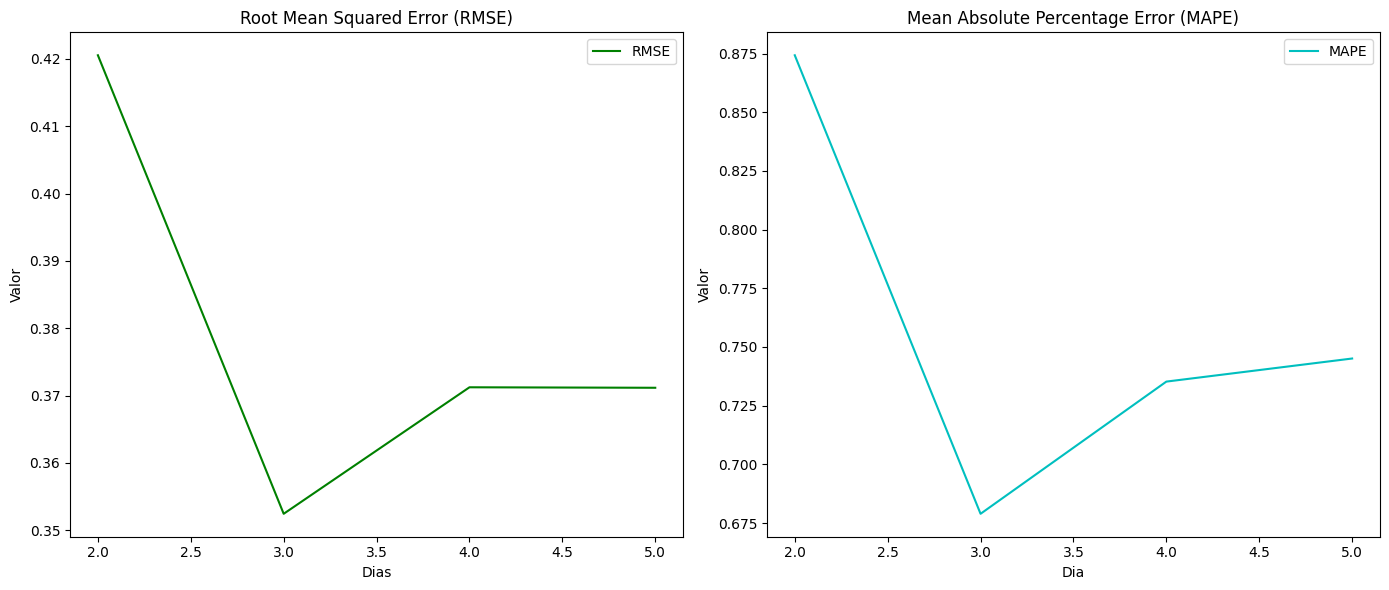

In [ ]:
plot_metrics(evolution_of_metrics(bb_teste_5_y, bb_mlp_5_5_previsao), title='bb_mlp_5_5_metrics')

##### Usar 5 dias para prever 10 dias

<p>Melhores resultados:<p>
<p>MSE: 0.0   <p>  
<p>RMSE: 0.0   <p>
<p>MAE: 0.0    <p>
<p>MAPE: 0.0% <p>
<p>R²: 0.0%   <p>

In [ ]:
avaliar_modelo(bb_teste_5_y, bb_mlp_5_10_previsao)

MSE: 1.138
RMSE: 1.067
MAE: 0.983
MAPE: 2.059%
R²: -344.695%


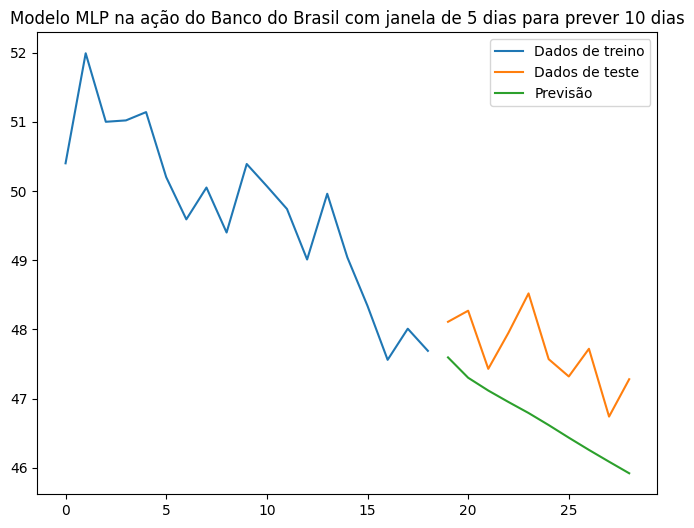

In [ ]:
plot_resultados(np.array(bb_close['Close'])[-30:-11], bb_teste_5_y, bb_mlp_5_10_previsao, save=True, title_plot='bb_mlp_5_10.png',
                title='Modelo MLP na ação do Banco do Brasil com janela de 5 dias para prever 10 dias')

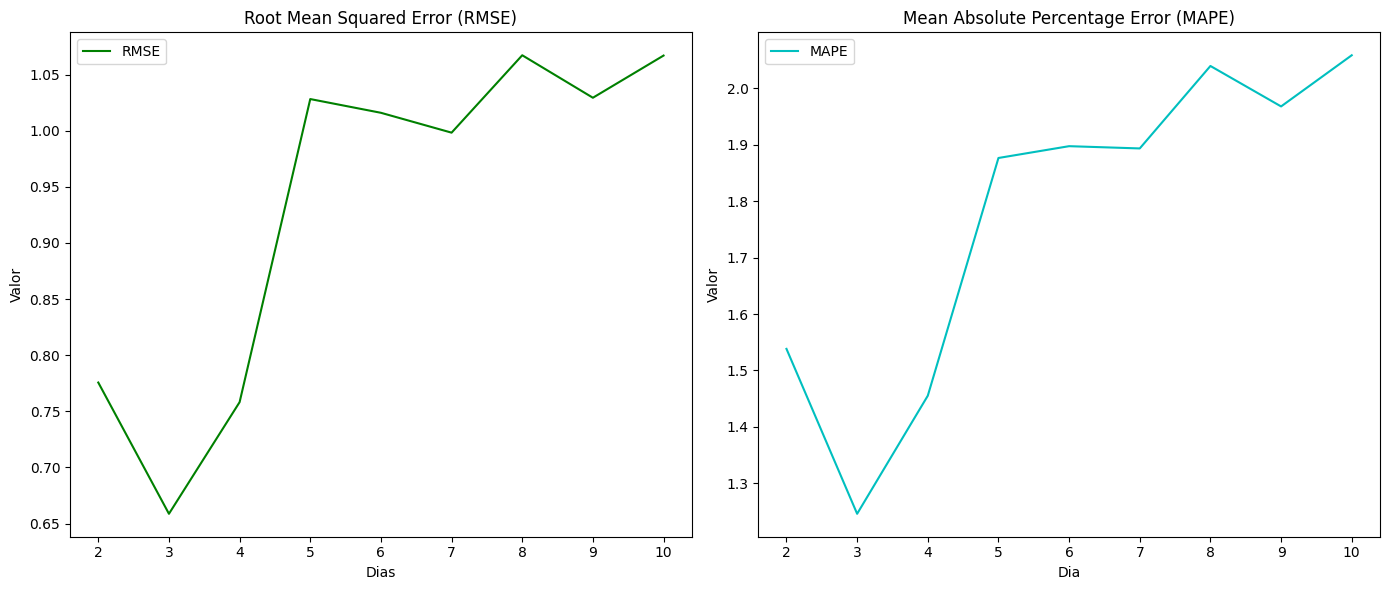

In [ ]:
plot_metrics(evolution_of_metrics(bb_teste_5_y, bb_mlp_5_10_previsao), title='bb_mlp_5_10_metrics')

#### Dados com pre-processsamento

##### Usar 5 dias para prever 5 dias

<p>Melhores resultados:<p>
<p>MSE: 0.438  <p>  
<p>RMSE: 0.662   <p>
<p>MAE: 0.586    <p>
<p>MAPE: 1.239% <p>
<p>R²: -291.065%   <p>

In [ ]:
avaliar_modelo(bb_teste_5_y, bb_mlp_5_5_previsao_diff)

MSE: 1.935
RMSE: 1.391
MAE: 1.089
MAPE: 2.305%
R²: -1626.356%


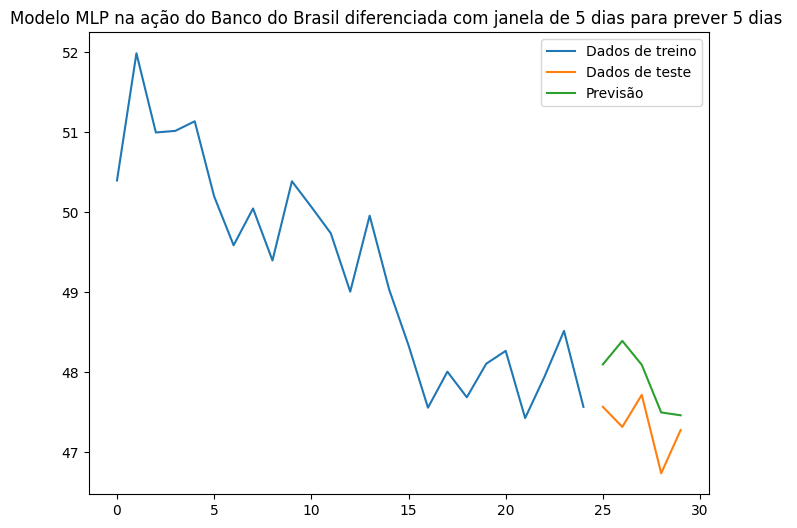

In [ ]:
plot_resultados(np.array(bb_close['Close'])[-30:-5], bb_teste_5_y, bb_mlp_5_5_previsao_diff, save=True, title_plot='bb_mlp_5_5_diff.png',
                title='Modelo MLP na ação do Banco do Brasil diferenciada com janela de 5 dias para prever 5 dias ')

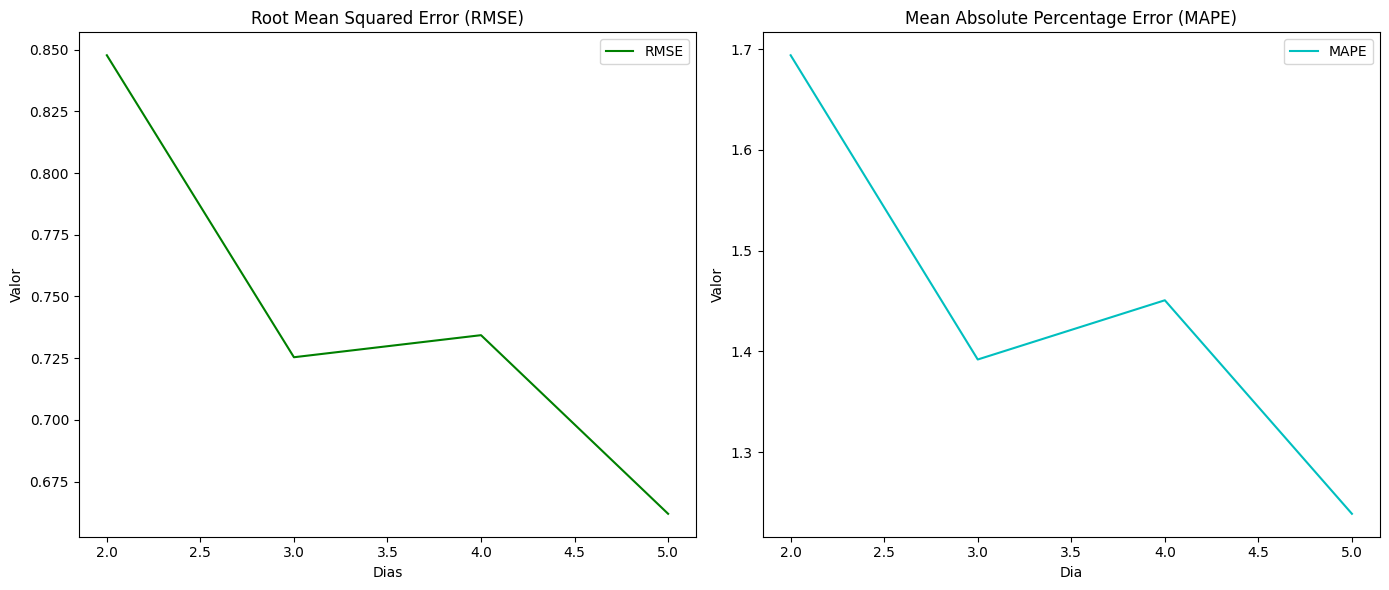

In [ ]:
plot_metrics(evolution_of_metrics(bb_teste_5_y, bb_mlp_5_5_previsao_diff), title='bb_mlp_5_5_diff_metrics')

## LSTM

### BB

#### Dados sem pre-processamento

##### Usar 5 dias para prever 5

<p>Melhores resultados:<p>
<p>MSE: 0.196  <p>  
<p>RMSE: 0.443   <p>
<p>MAE: 0.371    <p>
<p>MAPE: 0.786% <p>
<p>R²: -75.010%   <p>

In [ ]:
avaliar_modelo(bb_teste_5_y, bb_lstm_5_5_previsao)

MSE: 0.196
RMSE: 0.443
MAE: 0.371
MAPE: 0.786%
R²: -75.010%


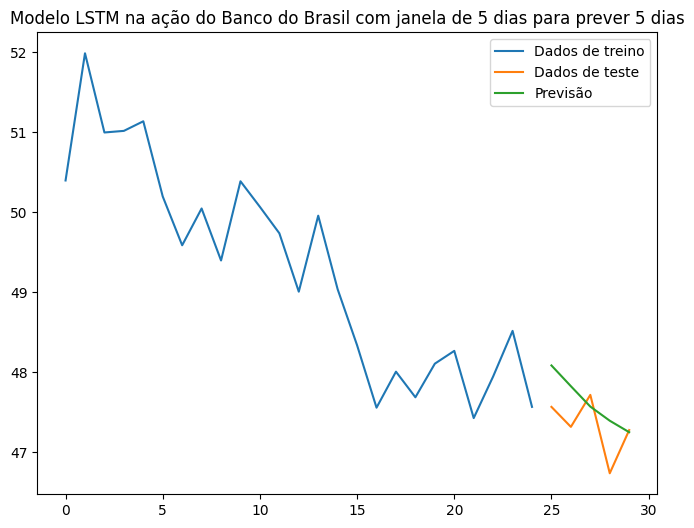

In [ ]:
plot_resultados(np.array(bb_close['Close'])[-30:-5], bb_teste_5_y, bb_lstm_5_5_previsao, save=True, title_plot='bb_lstm_5_5.png',
                title='Modelo LSTM na ação do Banco do Brasil com janela de 5 dias para prever 5 dias')

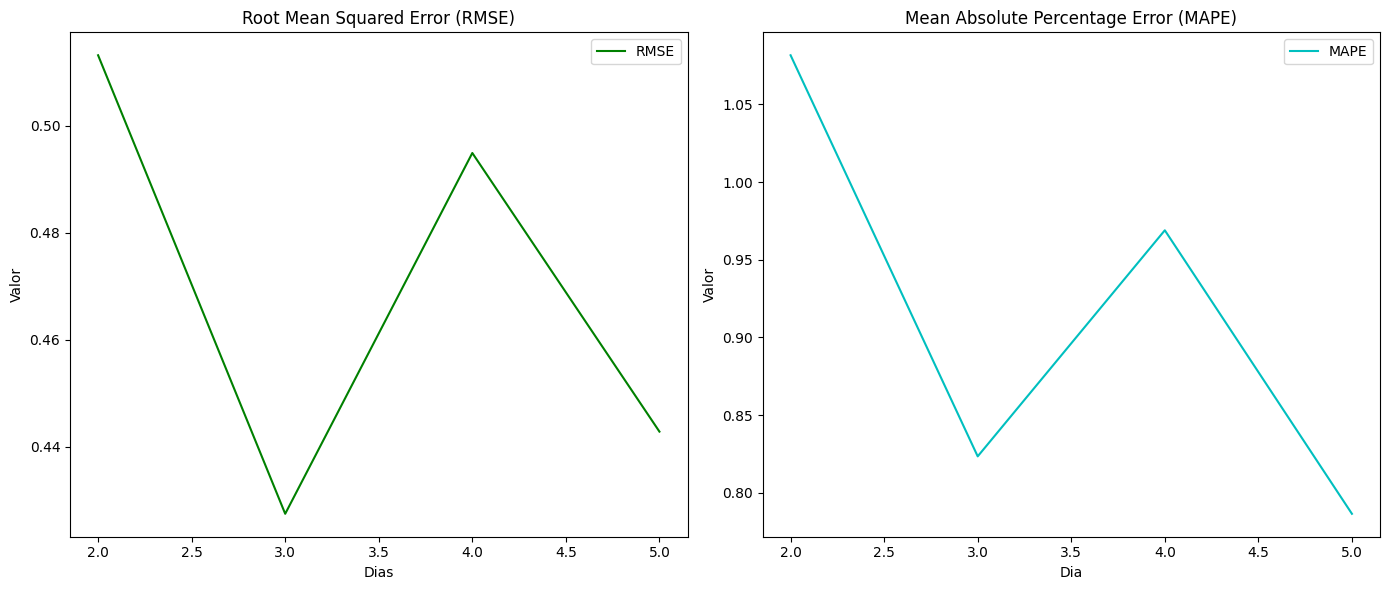

In [ ]:
plot_metrics(evolution_of_metrics(bb_teste_5_y, bb_lstm_5_5_previsao), title='bb_lstm_5_5_metrics')

#### Dados com pre-processamento

##### Usar 5 dias para prever 5 dias

<p>Melhores resultados:<p>
<p>MSE: 1.215  <p>  
<p>RMSE: 1.102   <p>
<p>MAE: 1.042    <p>
<p>MAPE: 2.207% <p>
<p>R²: -983.885%   <p>

In [ ]:
avaliar_modelo(bb_teste_5_y, bb_lstm_5_5_previsao_diff)

MSE: 1.736
RMSE: 1.317
MAE: 1.270
MAPE: 2.690%
R²: -1448.713%


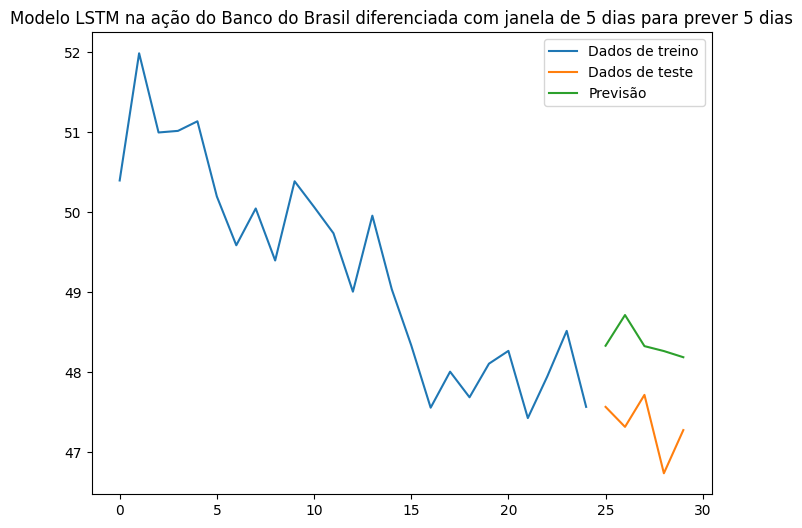

In [ ]:
plot_resultados(np.array(bb_close['Close'])[-30:-5], bb_teste_5_y, bb_lstm_5_5_previsao_diff, save=True, title_plot='bb_lstm_5_5_diff.png',
                title='Modelo LSTM na ação do Banco do Brasil diferenciada com janela de 5 dias para prever 5 dias')

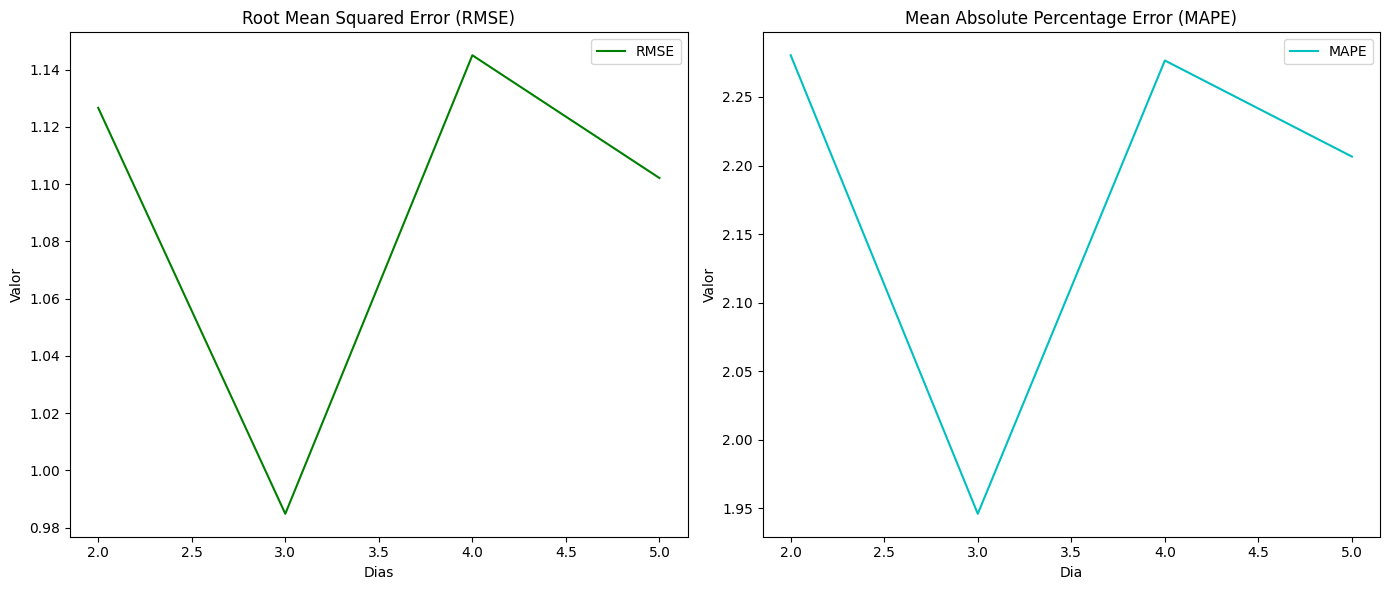

In [ ]:
plot_metrics(evolution_of_metrics(bb_teste_5_y, bb_lstm_5_5_previsao_diff), title='bb_lstm_5_5_diff_metrics')

## GRU

### BB

#### Dados sem pre-processamento

##### Usar 5 dias para prever 5 dias

<p>Melhores resultados:<p>
<p>MSE: 0.162   <p>  
<p>RMSE: 0.403   <p>
<p>MAE: 0.371    <p>
<p>MAPE: 0.783% <p>
<p>R²: -44.961%   <p>

In [ ]:
avaliar_modelo(bb_teste_5_y, bb_gru_5_5_previsao)

MSE: 0.239
RMSE: 0.489
MAE: 0.404
MAPE: 0.855%
R²: -112.981%


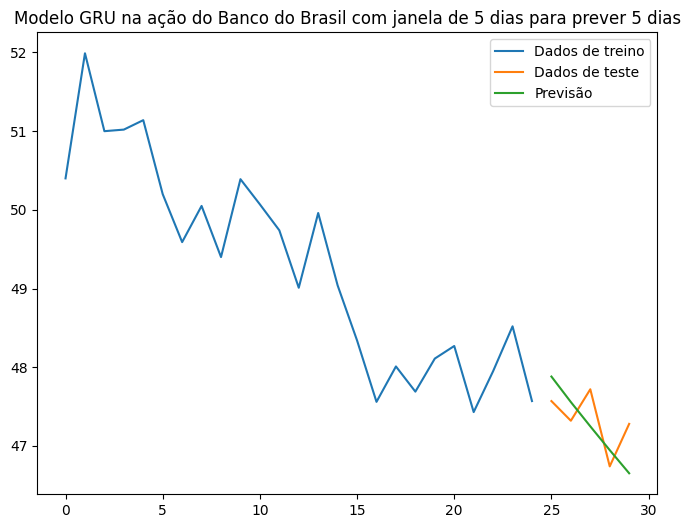

In [ ]:
plot_resultados(np.array(bb_close['Close'])[-30:-5], bb_teste_5_y, bb_gru_5_5_previsao, save=True, title_plot='bb_gru_5_5.png',
                title='Modelo GRU na ação do Banco do Brasil com janela de 5 dias para prever 5 dias')

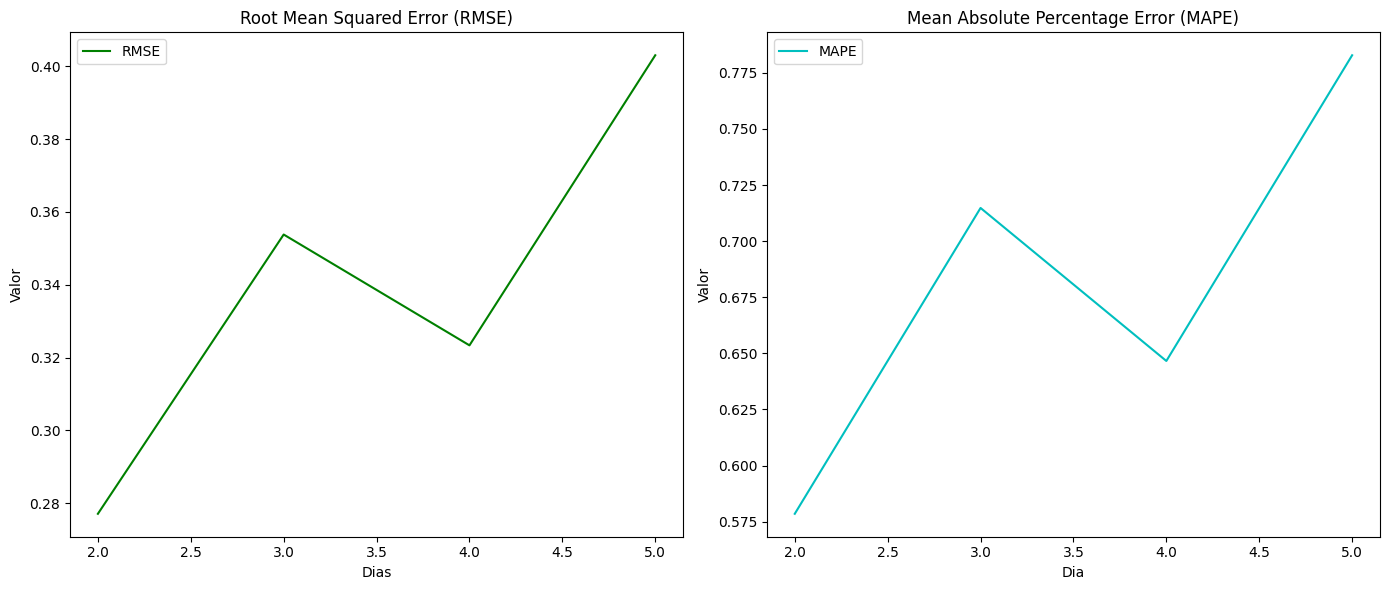

In [ ]:
plot_metrics(evolution_of_metrics(bb_teste_5_y, bb_gru_5_5_previsao), title='bb_gru_5_5_metrics')

#### Dados com pre-processamento

##### Usar 5 dias para prever 5 dias

<p>Melhores resultados:<p>
<p>MSE: 0.198   <p>  
<p>RMSE: 0.445   <p>
<p>MAE: 0.5401    <p>
<p>MAPE: 0.848% <p>
<p>R²: -76.478%   <p>

In [ ]:
avaliar_modelo(bb_teste_5_y, bb_gru_5_5_previsao_diff)

MSE: 1.508
RMSE: 1.228
MAE: 1.172
MAPE: 2.482%
R²: -1245.768%


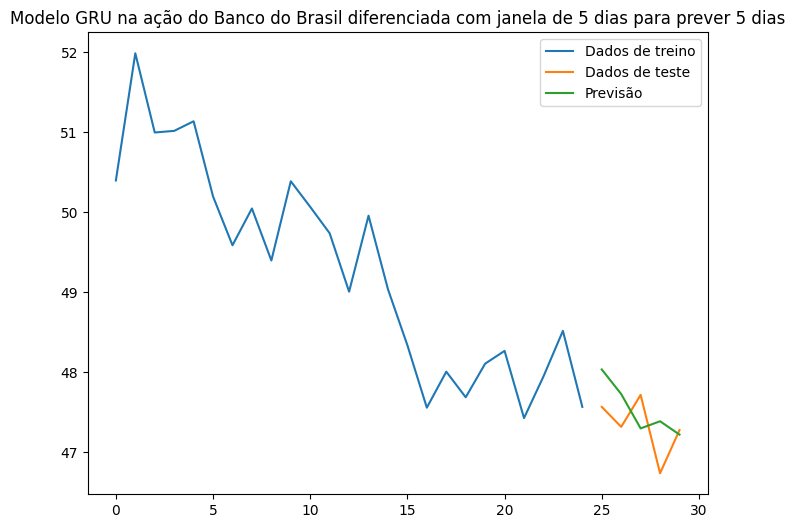

In [ ]:
plot_resultados(np.array(bb_close['Close'])[-30:-5], bb_teste_5_y, bb_gru_5_5_previsao_diff, save=True, title_plot='bb_gru_5_5_diff.png',
                title='Modelo GRU na ação do Banco do Brasil diferenciada com janela de 5 dias para prever 5 dias')

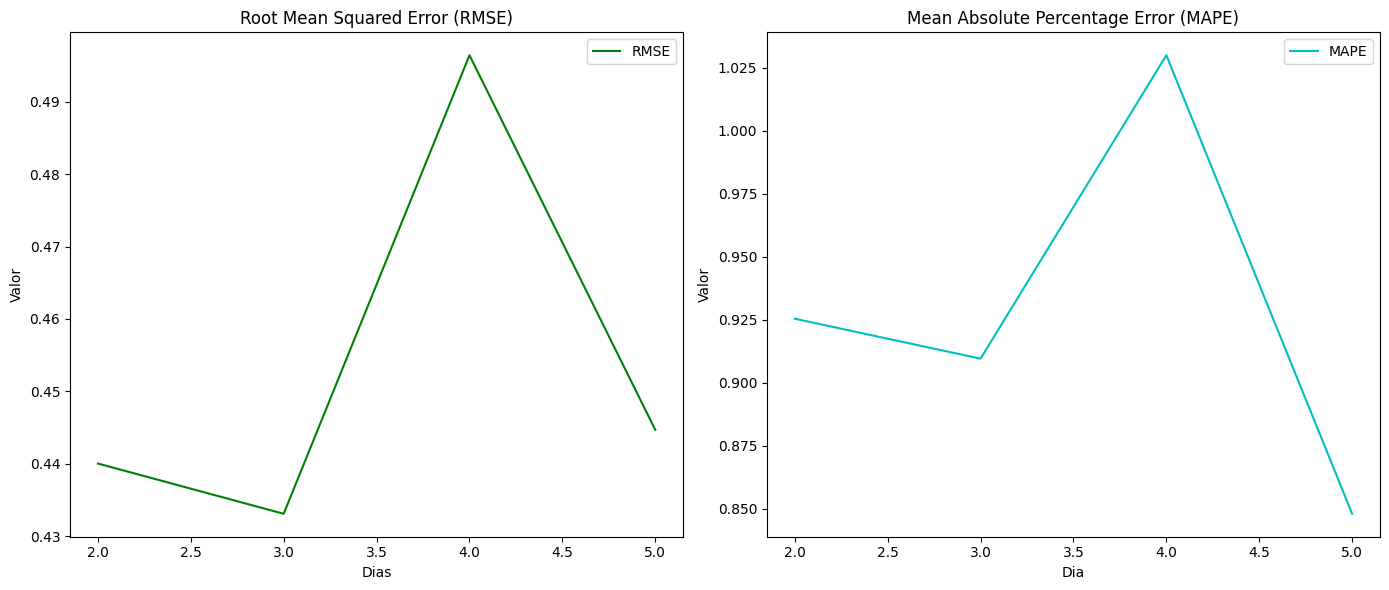

In [ ]:
plot_metrics(evolution_of_metrics(bb_teste_5_y, bb_gru_5_5_previsao_diff), title='bb_gru_5_5_diff_metrics')

## Transformers

### BB

#### Dados sem pre-processamento

##### Usar 5 dias para prever 5 dias

<p>Melhores resultados:<p>
<p>MSE: 0.160  <p>  
<p>RMSE: 0.400   <p>
<p>MAE: 0.291    <p>
<p>MAPE: 0.614% <p>
<p>R²: -43.087%   <p>

In [ ]:
avaliar_modelo(bb_teste_5_y, bb_transformer_5_5_previsao)

MSE: 0.160
RMSE: 0.400
MAE: 0.291
MAPE: 0.614%
R²: -43.087%


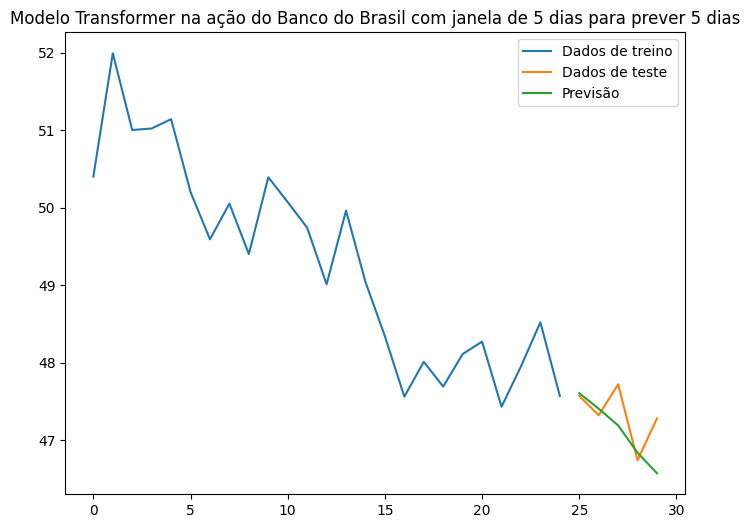

In [ ]:
plot_resultados(np.array(bb_close['Close'])[-30:-5], bb_teste_5_y, bb_transformer_5_5_previsao, save=True, title_plot='bb_transformer_5_5.png',
                title='Modelo Transformer na ação do Banco do Brasil com janela de 5 dias para prever 5 dias')

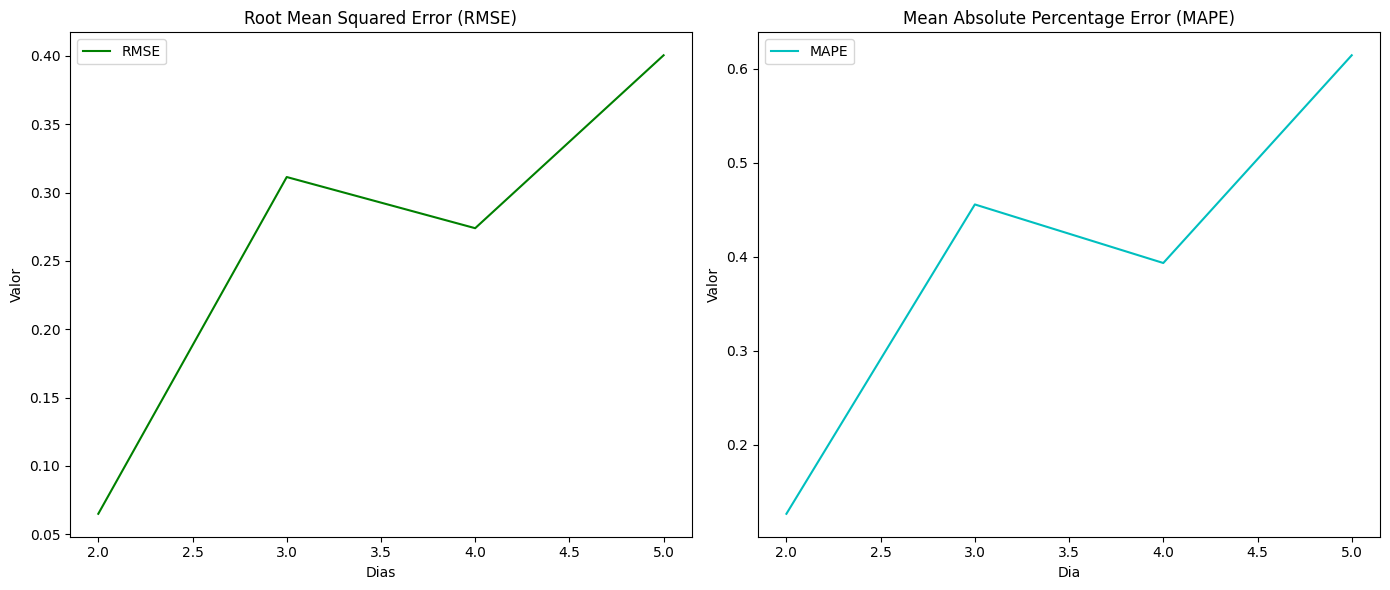

In [ ]:
plot_metrics(evolution_of_metrics(bb_teste_5_y, bb_transformer_5_5_previsao), title='bb_transformer_5_5_metrics')

#### Dados com pre-processamento

##### Usar 5 dias para prever 5 dias

<p>Melhores resultados:<p>
<p>MSE: 1.317  <p>  
<p>RMSE: 1.148   <p>
<p>MAE: 1.101    <p>
<p>MAPE: 2.332% <p>
<p>R²: -1075.205%   <p>

In [ ]:
avaliar_modelo(bb_teste_5_y, bb_transformer_5_5_previsao_diff)

MSE: 1.778
RMSE: 1.333
MAE: 1.286
MAPE: 2.723%
R²: -1486.516%


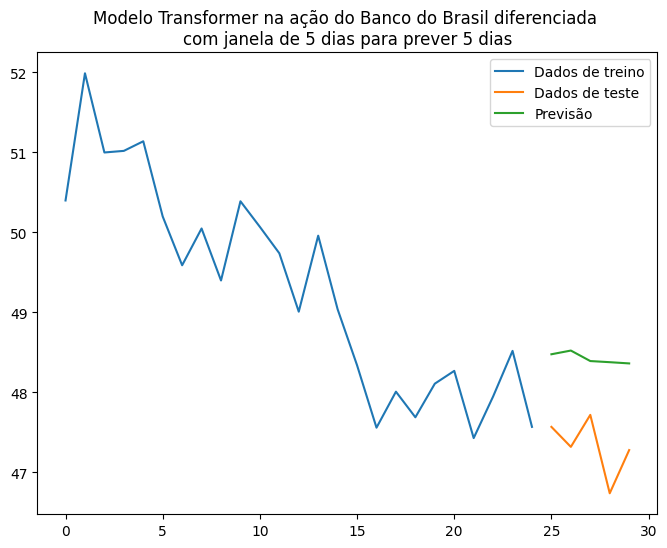

In [ ]:
plot_resultados(np.array(bb_close['Close'])[-30:-5], bb_teste_5_y, bb_transformer_5_5_previsao_diff, save=True, title_plot='bb_transformer_5_5_diff.png',
                title='Modelo Transformer na ação do Banco do Brasil diferenciada \ncom janela de 5 dias para prever 5 dias')

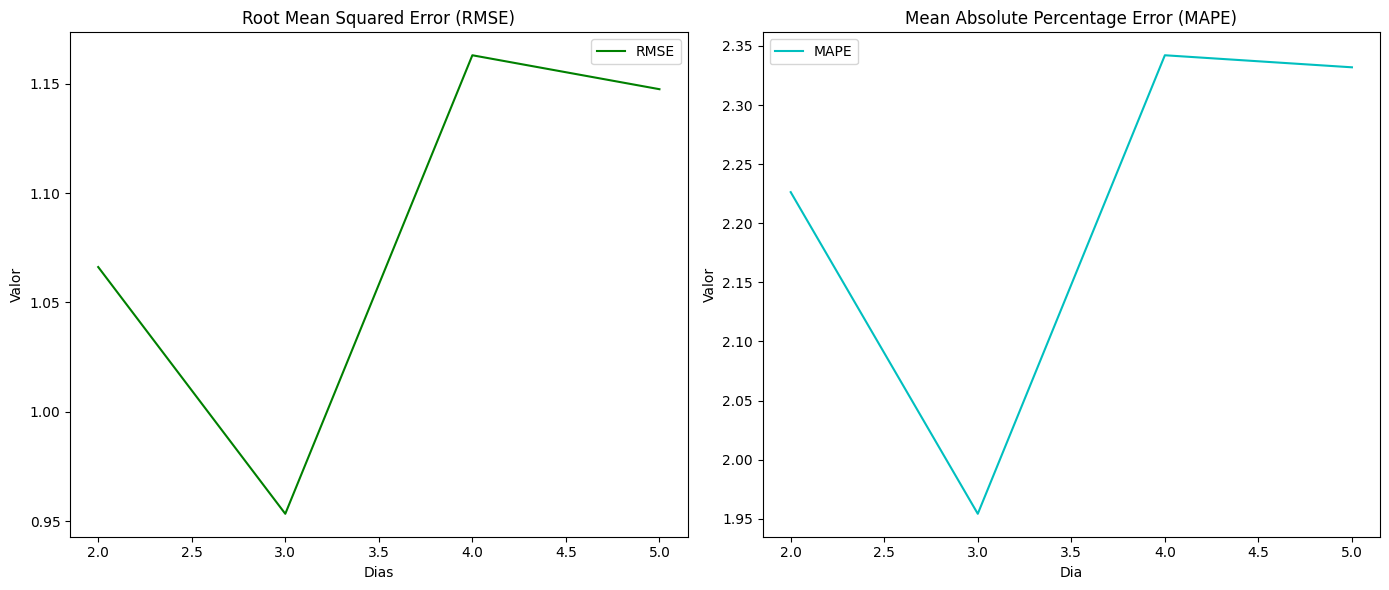

In [ ]:
plot_metrics(evolution_of_metrics(bb_teste_5_y, bb_transformer_5_5_previsao_diff), title='bb_transformer_5_5_diff_metrics')

# 5. Resultados

In [ ]:
## Tabelas das informações dos modelos como o MLP informando o número de neurônios, quantas camadas, épocas e função de ativação

## BB

### Sem pre-processamento

<p>Obs.: Os valores são referente a RMSE para uma determinada janela usando uma janela de 5 dias como entrada<p>
<table>
<thead>
<tr>
<th>Modelos</th>
<th>5 dias</th>
<th>10 dias</th>
<th>15 dias</th>
<th>20 dias</th>
</tr>
</thead>
<tbody>

<tr>
<td>SARIMA</td>
<td>1.301</td>
<td>0.502</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>Holt-winters</td>
<td>0.573</td>
<td>0.488</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>MLPs</td>
<td>0.371</td>
<td>00</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>LSTM</td>
<td>0.443</td>
<td>00</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>GRU</td>
<td>0.403</td>
<td>00</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>Transformers</td>
<td>0.400</td>
<td>00</td>
<td>00</td>
<td>00</td>
</tr>

</tbody>
</table>

<p>Obs.: Os valores são referente a MAPE para uma determinada janela usando uma janela de 5 dias como entrada<p>
<table>
<thead>
<tr>
<th>Modelos</th>
<th>5 dias</th>
<th>10 dias</th>
<th>15 dias</th>
<th>20 dias</th>
</tr>
</thead>
<tbody>

<tr>
<td>SARIMA</td>
<td>2.664%</td>
<td>0.842%</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>Holt-winters</td>
<td>0.966%</td>
<td>0.863%</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>MLPs</td>
<td> 0.745%</td>
<td>00</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>LSTM</td>
<td>0.786%</td>
<td>00</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>GRU</td>
<td>0.783%</td>
<td>00</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>Transformers</td>
<td>0.614%</td>
<td>00</td>
<td>00</td>
<td>00</td>
</tr>

</tbody>
</table>

### Com pre-processamento

<p>Obs.: Os valores são referente a RMSE para uma determinada janela usando uma janela de 5 dias como entrada<p>
<table>
<thead>
<tr>
<th>Modelos</th>
<th>5 dias</th>
<th>10 dias</th>
<th>15 dias</th>
<th>20 dias</th>
</tr>
</thead>
<tbody>

<tr>
<td>SARIMA</td>
<td>1.301</td>
<td>0.502</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>Holt-winters</td>
<td> 0.596</td>
<td>0.606</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>MLPs</td>
<td>0.662</td>
<td>00</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>LSTM</td>
<td>1.102</td>
<td>00</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>GRU</td>
<td>0.445</td>
<td>00</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>Transformers</td>
<td>1.148</td>
<td>00</td>
<td>00</td>
<td>00</td>
</tr>

</tbody>
</table>

<p>Obs.: Os valores são referente a MAPE para uma determinada janela usando uma janela de 5 dias como entrada<p>
<table>
<thead>
<tr>
<th>Modelos</th>
<th>5 dias</th>
<th>10 dias</th>
<th>15 dias</th>
<th>20 dias</th>
</tr>
</thead>
<tbody>

<tr>
<td>SARIMA</td>
<td>2.662%</td>
<td>0.842%</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>Holt-winters</td>
<td>0.987%</td>
<td>1.122%</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>MLPs</td>
<td>1.239%</td>
<td>00</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>LSTM</td>
<td>2.207%</td>
<td>00</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>GRU</td>
<td>0.848%</td>
<td>00</td>
<td>00</td>
<td>00</td>
</tr>

<tr>
<td>Transformers</td>
<td>2.332%</td>
<td>00</td>
<td>00</td>
<td>00</td>
</tr>

</tbody>
</table>